## Import Libaries & Data

In [2]:
import warnings
warnings.filterwarnings('ignore')

#basic libraries
import pandas as pd
import numpy as np

#visualization models
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

#Common model helpers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

#model algorithm
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import (RandomForestClassifier,
                                AdaBoostClassifier,
                                GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

In [3]:
#Input dataset
hdb_resale = pd.read_csv('./Data/flat_price_2017_2023.csv')
cpi_housing = pd.read_csv(r'./Data/CPI_2000to2022Feb.csv')

In [3]:
hdb_resale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146872 entries, 0 to 146871
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                146872 non-null  object 
 1   town                 146872 non-null  object 
 2   flat_type            146872 non-null  object 
 3   block                146872 non-null  object 
 4   street_name          146872 non-null  object 
 5   storey_range         146872 non-null  object 
 6   floor_area_sqm       146872 non-null  float64
 7   flat_model           146872 non-null  object 
 8   lease_commence_date  146872 non-null  int64  
 9   remaining_lease      146872 non-null  object 
 10  resale_price         146872 non-null  float64
 11  full_address         146872 non-null  object 
 12  Longitude            146842 non-null  object 
 13  Latitude             146872 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 15.7+ MB


In [58]:
hdb_resale.shape

(146872, 23)

In [4]:
hdb_resale.head()

month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price                     full_address      Longitude    Latitude  
0      232000.0  406 ANG MO KIO AVE 10 Singapore  1.038.567.853  13.699.405  
1      250000.0   108 ANG MO KIO AVE 4 Singapore  1.038.399.171  13.792.416  
2      262000.0   602 ANG MO KIO AVE 5 Singapore  1.038.354.254     138.076  
3      265000.0  465 ANG MO KIO AVE 10 Singapore  1.038.571.753  13.662.228  
4      265000.0   601 ANG MO KIO AVE 5 Singapore  1.038.350.755   1.380.987

In [5]:
# Let see the statistic information of the data
hdb_resale.describe()

floor_area_sqm  lease_commence_date  resale_price
count   146872.000000        146872.000000  1.468720e+05
mean        97.599526          1995.516661  4.783159e+05
std         24.088081            13.730146  1.655338e+05
min         31.000000          1966.000000  1.400000e+05
25%         82.000000          1985.000000  3.580000e+05
50%         94.000000          1996.000000  4.480000e+05
75%        113.000000          2007.000000  5.658000e+05
max        249.000000          2019.000000  1.418000e+06

In [6]:
cpi_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tranc_Yr     278 non-null    int64  
 1   Tranc_Mth    278 non-null    object 
 2   CPI Housing  278 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.6+ KB


In [7]:
cpi_housing.tail()

Tranc_Yr Tranc_Mth  CPI Housing
273      2022   October      106.702
274      2022  November      108.770
275      2022  December      109.040
276      2023   January      109.290
277      2023  February      109.350

## Data Processing

### 1. Split 'month' to 'Tranc_Yr' and 'Tranc_Mth' columns

In [8]:
#Convert month to datetime and format to Month period
hdb_resale['month'] = pd.to_datetime(hdb_resale['month'])

#Get 'Tranc_Yr' and 'Tranc_Mth' columns
hdb_resale['Tranc_Yr'] = hdb_resale['month'].dt.year
hdb_resale['Tranc_Mth'] = hdb_resale['month'].dt.month_name()

### 2. Add Consumer Price Index for Housing Get Adjusted_Price

In [9]:
# Update and merge CPI
hdb_resale = pd.merge(hdb_resale, cpi_housing,left_on=['Tranc_Yr', 'Tranc_Mth'],right_on=['Tranc_Yr', 'Tranc_Mth'],how='left')

In [56]:
#Add "Adjusted-Price" calculated from CPI Housing
hdb_resale['Adjusted_Price'] =  hdb_resale['resale_price'] * (109.350 / hdb_resale['CPI Housing'])

#Round the Adjusted_Price round to nearest thousand
hdb_resale['Adjusted_Price'] =hdb_resale.Adjusted_Price.round(-2)

In [11]:
hdb_resale.head()

month        town flat_type block        street_name storey_range  \
0 2017-01-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1 2017-01-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2 2017-01-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3 2017-01-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4 2017-01-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0            44.0        Improved                 1979  61 years 04 months   
1            67.0  New Generation                 1978  60 years 07 months   
2            67.0  New Generation                 1980  62 years 05 months   
3            68.0  New Generation                 1980   62 years 01 month   
4            67.0  New Generation                 1980  62 years 05 months   

   resale_price                     full_address      Longitude    Latitude  \
0      232000.0  406 ANG MO KIO AVE 10 Singapore  1.038.567.853  13.699.405   
1      250000.0   108 ANG MO KIO AVE 4 Singapore  1.038.399.171  13.792.416   
2      262000.0   602 ANG MO KIO AVE 5 Singapore  1.038.354.254     138.076   
3      265000.0  465 ANG MO KIO AVE 10 Singapore  1.038.571.753  13.662.228   
4      265000.0   601 ANG MO KIO AVE 5 Singapore  1.038.350.755   1.380.987   

   Tranc_Yr Tranc_Mth  CPI Housing  Adjusted_Price  
0      2017   January      106.614        238000.0  
1      2017   January      106.614        256400.0  
2      2017   January      106.614        268700.0  
3      2017   January      106.614        271800.0  
4      2017   January      106.614        271800.0

### 3. Split 'years' to 'remaining_yr' and 'remaining_month' columns

In [12]:
#split remaining_lease into year and month columns
hdb_resale[['remaining_yr','remaining_month']] = hdb_resale.remaining_lease.str.split("years ", expand=True)

#remove the word 'years' and empty spaces
hdb_resale['remaining_yr'] = hdb_resale['remaining_yr'].replace({r'\byears?\b': '', ' ': ''}, regex=True)

#delete 'months' and empty spaces in remaining_month
hdb_resale['remaining_month'] = hdb_resale['remaining_month'].replace({r'\bmonths?\b': '', ' ': ''}, regex=True)

In [13]:
# list values of remaining_month
hdb_resale.remaining_month.unique()

array(['04', '07', '05', '01', None, '06', '08', '10', '03', '09', '11',
       '02', '0'], dtype=object)

In [14]:
#fill null values with 0
hdb_resale['remaining_month'] = hdb_resale.remaining_month.fillna(0)

#convert remaining_yr to integer
hdb_resale['remaining_yr'] = hdb_resale['remaining_yr'].astype(int)

#convert remaining_month to integer
hdb_resale['remaining_month'] = hdb_resale['remaining_month'].astype(int)

#turn remaining month /12 to get decimal
hdb_resale['remaining_month'] = hdb_resale['remaining_month'] / 12

#change compute remaining_year by adding remaining_month
hdb_resale['remaining_yr'] = hdb_resale['remaining_yr'] + hdb_resale['remaining_month']

#drop remaining_month
hdb_resale.drop('remaining_month', axis = 1, inplace=True)

In [15]:
hdb_resale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146872 entries, 0 to 146871
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                146872 non-null  datetime64[ns]
 1   town                 146872 non-null  object        
 2   flat_type            146872 non-null  object        
 3   block                146872 non-null  object        
 4   street_name          146872 non-null  object        
 5   storey_range         146872 non-null  object        
 6   floor_area_sqm       146872 non-null  float64       
 7   flat_model           146872 non-null  object        
 8   lease_commence_date  146872 non-null  int64         
 9   remaining_lease      146872 non-null  object        
 10  resale_price         146872 non-null  float64       
 11  full_address         146872 non-null  object        
 12  Longitude            146842 non-null  object        
 13  Latitude      

### 4. Split 'storey_range' into 'lower_flr', 'median_flr', 'higher_flr'

In [16]:
# Split the storey_range column into lower, mid, and higher columns
hdb_resale[['lower_flr', 'higher_flr']] = hdb_resale['storey_range'].str.split(' TO ', expand=True)

# Calculate the median value for each range and add a mid column
hdb_resale['median_flr'] = hdb_resale.apply(lambda row: str((int(row['lower_flr']) + int(row['higher_flr'])) // 2), axis=1)

# Convert 'mid' column as integer
hdb_resale['median_flr'] = hdb_resale['median_flr'].astype(int) 

**Explanation to above steps:**

As we are not sure exactly which storey the unit is located, we use the median value as the unit's storey.

### 5. Get Distance from CBD

Using haversine_distance. We will be taking Raffles Place at the City Centre (CBD)

In [17]:
hdb_resale[['Latitude', 'Longitude']].isnull().sum()

Latitude      0
Longitude    30
dtype: int64

In [18]:
# Create a New column to calculate the distance from Raffles Place (CBD)

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    
    # Compute the Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Raffles Place coordinates
raffles_place_latitude, raffles_place_longitude = 1.2833, 103.8501
# Convert the Latitude and Longitude columns to numeric types if they are not already
hdb_resale['Latitude'] = pd.to_numeric(hdb_resale['Latitude'], errors='coerce')
hdb_resale['Longitude'] = pd.to_numeric(hdb_resale['Longitude'], errors='coerce')
# Fill missing values by meadian values
hdb_resale['Latitude'].fillna(hdb_resale['Latitude'].median(), inplace=True)
hdb_resale['Longitude'].fillna(hdb_resale['Longitude'].median(), inplace=True)

# Calculate the distance between each location and Raffles Place
hdb_resale['Distance_from_CBD'] = haversine_distance(hdb_resale['Latitude'], hdb_resale['Longitude'],
                                                    raffles_place_latitude, raffles_place_longitude)

In [19]:
hdb_resale[['Latitude', 'Longitude']].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

In [20]:
haversine_distance(hdb_resale['Latitude'], hdb_resale['Longitude'],
                    raffles_place_latitude, raffles_place_longitude)

0         15219.866341
1         15219.866341
2         15210.637211
3         15219.866341
4         15219.866341
              ...     
146867    15219.866341
146868    15219.866341
146869    15219.866341
146870    15219.866341
146871    15219.866341
Length: 146872, dtype: float64

### 6. Create a new DataFrame with only Feature Columns that will be used. 

In [22]:
#Create a new DataFrame call df_resale as these will be the features we are using for modelling
df_resale = hdb_resale[['Tranc_Yr', 'Tranc_Mth', 'town', 'flat_type', 'flat_model', 'median_flr',
                        'Distance_from_CBD', 'remaining_yr', 'floor_area_sqm', 'resale_price', 'Adjusted_Price']]

df_resale

Tranc_Yr Tranc_Mth        town  flat_type      flat_model  median_flr  \
0           2017   January  ANG MO KIO     2 ROOM        Improved          11   
1           2017   January  ANG MO KIO     3 ROOM  New Generation           2   
2           2017   January  ANG MO KIO     3 ROOM  New Generation           2   
3           2017   January  ANG MO KIO     3 ROOM  New Generation           5   
4           2017   January  ANG MO KIO     3 ROOM  New Generation           2   
...          ...       ...         ...        ...             ...         ...   
146867      2023  February      YISHUN     5 ROOM        Improved           2   
146868      2023  February      YISHUN     5 ROOM        Improved          11   
146869      2023  February      YISHUN  EXECUTIVE       Apartment           8   
146870      2023  February      YISHUN  EXECUTIVE      Maisonette          11   
146871      2023  February      YISHUN  EXECUTIVE       Apartment           2   

        Distance_from_CBD  remaining_yr  floor_area_sqm  resale_price  \
0            15219.866341     61.333333            44.0      232000.0   
1            15219.866341     60.583333            67.0      250000.0   
2            15210.637211     62.416667            67.0      262000.0   
3            15219.866341     62.083333            68.0      265000.0   
4            15219.866341     62.416667            67.0      265000.0   
...                   ...           ...             ...           ...   
146867       15219.866341     64.083333           127.0      700000.0   
146868       15219.866341     64.166667           122.0      700000.0   
146869       15219.866341     68.416667           181.0     1068000.0   
146870       15219.866341     64.833333           146.0      838000.0   
146871       15219.866341     63.333333           142.0      765000.0   

        Adjusted_Price  
0             238000.0  
1             256400.0  
2             268700.0  
3             271800.0  
4             271800.0  
...                ...  
146867        700000.0  
146868        700000.0  
146869       1068000.0  
146870        838000.0  
146871        765000.0  

[146872 rows x 11 columns]

## EDA - Overall Descriptive Stats

### Descriptive Stats

In [23]:
yr_resale = df_resale.groupby(['Tranc_Yr', 'flat_type'])['resale_price'].describe().round()
yr_resale.style.format('{:.0f}', na_rep="")\
.background_gradient(cmap='YlOrRd', text_color_threshold=0.1)\
.bar(subset=['count'], color='#01C6BA', align='zero')

**Notes:**

1. Nhu cầu về loại căn hộ 3 đến 5 phòng và Executive đã tăng trưởng ổn định từ năm 2017 đến năm 2021 và giảm nhẹ vào năm 2022.
2. Phòng Năm có độ lệch chuẩn cao liên tục, tiếp theo là Phòng Bốn và Phòng Executive.
3. Giá bán lại có sự phân bổ tốt cho tất cả các loại căn hộ trong 3 tứ phân vị đầu tiên. Tuy nhiên, giá trị tối đa bắt đầu cho thấy xu hướng thú vị đối với tất cả các loại phẳng.
4. Căn hộ 5 phòng có giá cao nhất hầu như hàng năm. Tiếp theo là căn hộ Executive và căn hộ 4 phòng
5. Hồ sơ trước đây cho thấy MOP** (Thời gian lưu trú tối thiểu) mới của các căn hộ DBSS và BTO đang đẩy mức giá trần lên tới 1 triệu USD. Dữ liệu mô tả tiếp theo sẽ đưa ra một bức tranh rõ ràng về mức độ ảnh hưởng của các căn hộ loại cao cấp đến giá bán lại và gây chú ý trên các tin tức bất động sản.

In [24]:
type_model = df_resale.groupby(['flat_type', 'flat_model'])['resale_price'].describe().round()
type_model.style.format('{:.0f}', na_rep="")\
.background_gradient(cmap='YlOrRd', text_color_threshold=0.1)\
.bar(subset=['count'], color='#01C6BA', align='zero')

**Transaction Count**

1. Căn hộ 4 phòng Model A được giao dịch nhiều nhất trong 6 năm qua với 36.609 căn.
2. Tiếp theo là căn hộ mẫu 5 phòng cải tiến với tổng số 25.862 giao dịch.
3. Phổ biến nhất là mô hình 3 phòng thế hệ mới với 11.754 giao dịch được thực hiện.
4. Các mẫu cụ thể như Căn hộ liền kề, Cải tiến, Căn hộ cao cấp, DBSS, Sân thượng, Căn hộ cao cấp Gác xép, Mansionette và Loại S1 & S2 đang có giá bán lại cao trong nhóm loại căn hộ của riêng mình.
5. Thử thách dự đoán giá cho các mô hình nêu trên có thể là thách thức vì một số mô hình này là duy nhất với số lượng giao dịch nhỏ hạn chế. Vì vậy, hồi quy tuyến tính đơn giản như vậy có thể không dự đoán được chính xác những căn hộ có giá cao hơn.

#### A Look at Price with CPI Adjustment

In [25]:
type_model = df_resale.groupby(['flat_type', 'flat_model'])['Adjusted_Price'].describe().round()
type_model.style.format('{:.0f}', na_rep="")\
.background_gradient(cmap='YlOrRd', text_color_threshold=0.1)\
.bar(subset=['count'], color='#01C6BA', align='zero')

Khi CPI được áp dụng trên giá bán lại, ta có thể thấy nhiều mẫu căn hộ cao cấp / đặc biệt vượt qua 1,5 triệu SGD vào năm 2023 ở loại căn hộ Ba đến Năm Phòng.
[2022 Article on flats selling above SGD1million](https://mothership.sg/2022/05/henderson-road-flat-record-price/)

Một điều thú vị cần lưu ý là ngay cả sau khi điều chỉnh CPI, vẫn có những mẫu căn hộ loại 3 đến 5 phòng có giá từ 300 nghìn SGD500 nghìn SGD. Mặc dù những tin tức gần đây về các cặp vợ chồng mới cưới phàn nàn về giá căn hộ HDB bán lại cao, hầu hết các căn hộ bán lại thực sự được chốt khá gần với giá căn hộ HDB mới. 

| Flat Type | Selling Price (Excluding Grants) | Selling Price (Including Grants) |
|-----------|----------------------------------|----------------------------------|  
| 3-Room    | From SGD215,000                  | From SGD140,000                  |
| 4-Room    | From SGD236,000                  | From SGD191,000                  |
|5-Room     | From SGD440,000                  | From SGD410,000                  |
| *table taken from www.hdb.gov.sg*   |

Nếu người mua không quá kén chọn địa điểm, giá bán lại thực sự có thể phù hợp với giá căn hộ mới. 'Phí bảo hiểm' mà người mua lại căn hộ thường phải trả là vị trí gần thành phố, sự tiện lợi của các tiện ích lân cận và hệ thống giao thông.



#### Percentage of Flats that are Selling above SGD1million

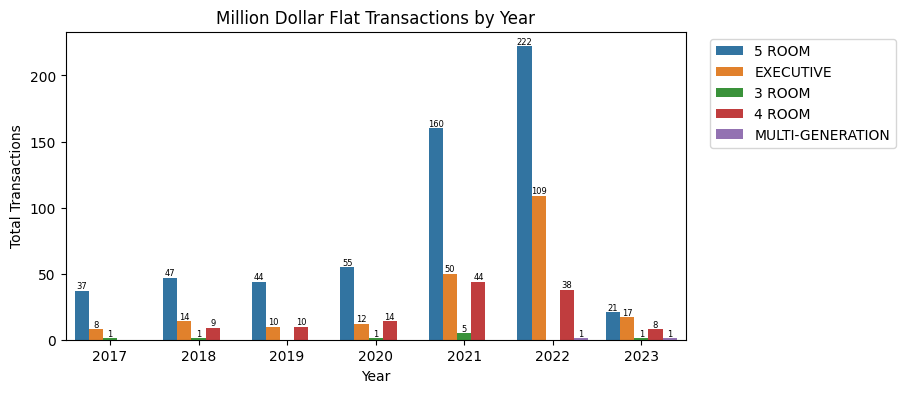

In [26]:
#Get flat selling above SGD1million
mil_resale = df_resale[df_resale['resale_price'] >= 1000000]

#Countplot of flats above SGD1million
fig, ax = plt.subplots(figsize=(8, 4))
mil_count = sns.countplot(data=mil_resale, x='Tranc_Yr', hue='flat_type')
mil_count.legend(loc='right', bbox_to_anchor=(1.35, 0.8), ncol=1)
for container in ax.containers:
    ax.bar_label(container, size=6)
plt.xlabel("Year")
plt.ylabel("Total Transactions")
plt.title("Million Dollar Flat Transactions by Year")

plt.show()

**Note:**

Mặc dù "Căn hộ triệu đô" đã gây chú ý trong gần 6 năm, nhưng vẫn có sự gia tăng đáng kể về số lượng căn hộ 1 triệu SGD được giao dịch từ năm 2021. Trong đó tổng số lượng giao dịch tăng gấp ba/gấp bốn lần kể từ năm 2020.

### Data Visualization

#### Pair Plot

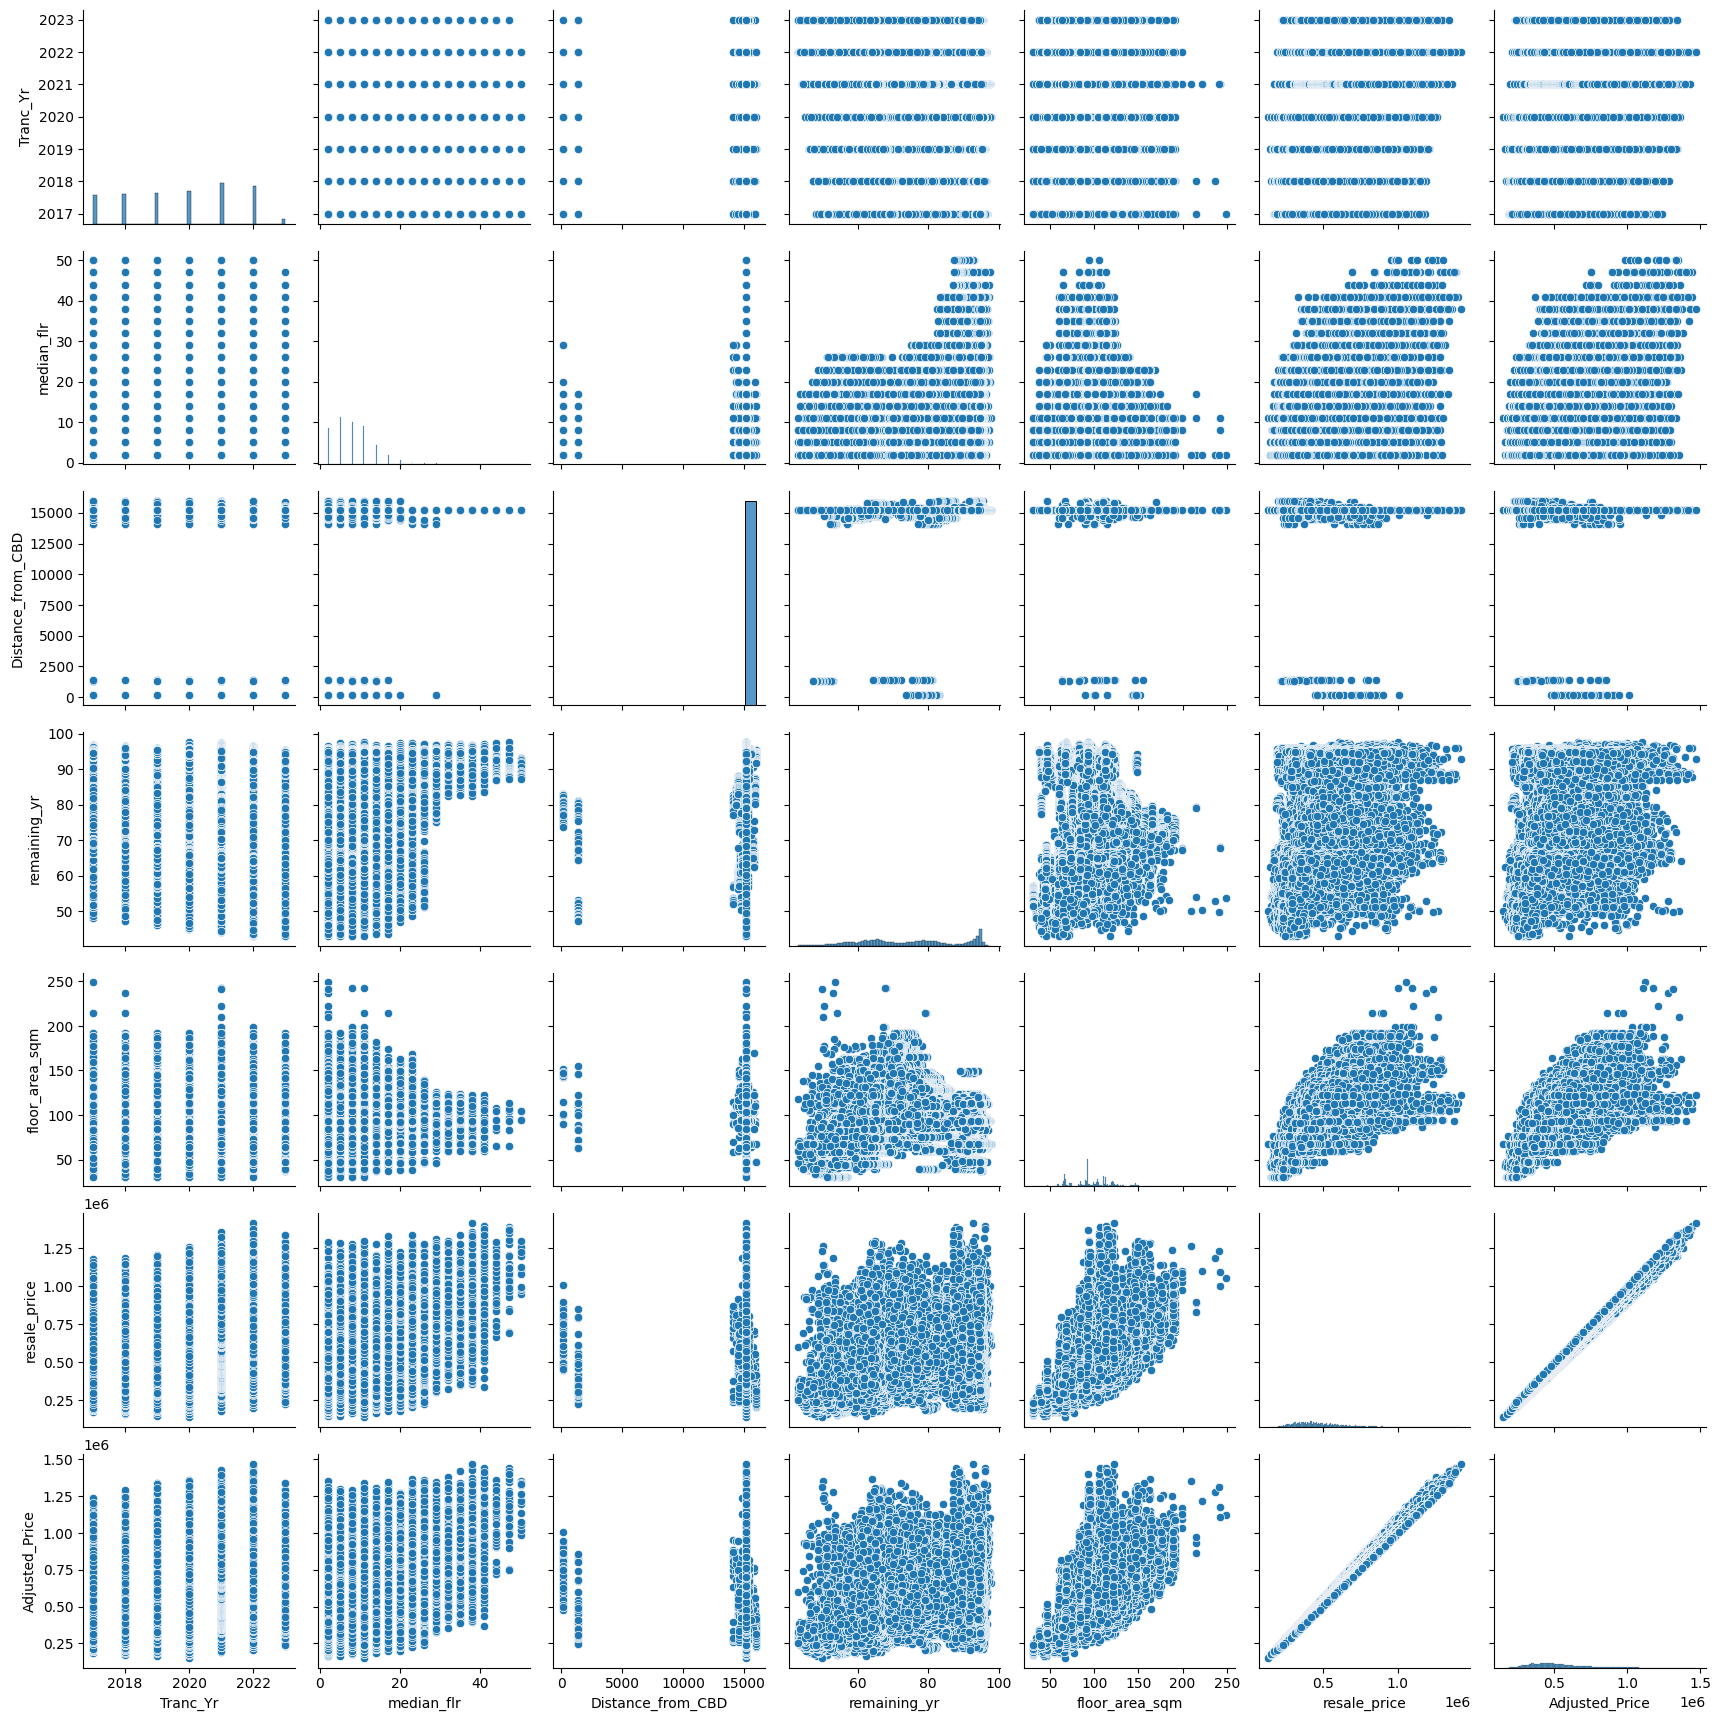

In [27]:
sns.pairplot(df_resale)
plt.show()

**Notes:**

1. Median_flr cho thấy giá dịch chuyển lên trên đối với các căn hộ có tầng cao hơn.
2. Diện tích sàn_m2 ảnh hưởng trực tiếp đến giá bán lại. Mặc dù khá nhiều căn hộ có diện tích từ 100m2 đến 150m2 cũng đang có giá cao.
3. Giá căn hộ thường đắt hơn khi ở gần khu vực trung tâm thành phố. Những người ở xa CBD thường có giá thấp hơn.
4. Điều đáng ngạc nhiên là số năm (tuổi) cho thuê còn lại của căn hộ không thực sự ảnh hưởng đến giá căn hộ bán lại.
5. Sự phân bổ giá bán lại lệch phải hơn. Điều đó có nghĩa là hầu hết các căn hộ vẫn được giao dịch dưới mức giá bán lại trung bình tổng thể.

##### Distribution of HDB resale price in Singapore

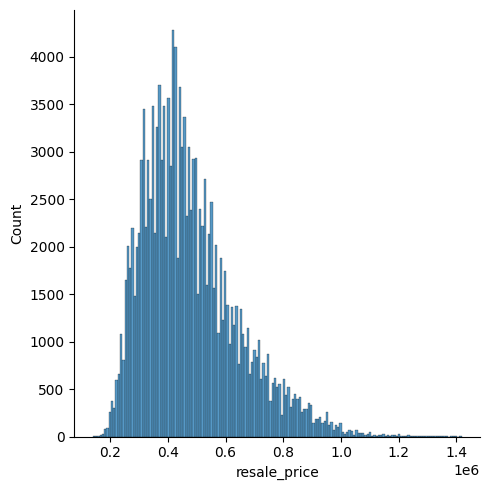

In [28]:
sns.displot(hdb_resale['resale_price'])

Sự phân bổ hơi lệch về bên trái.

#### Correlation Heat Map

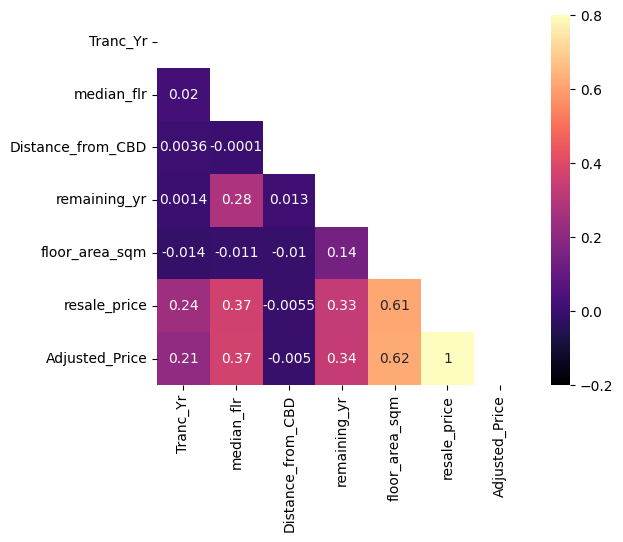

In [29]:
# Convert non-numeric values to NaN
numeric_columns = df_resale.select_dtypes(include='number').columns
df_resale_numeric = df_resale[numeric_columns]

# Create a mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(df_resale_numeric.corr(), dtype=bool))

# Create the heatmap with the mask and square parameters
sns.heatmap(df_resale_numeric.corr(), cmap="magma", mask=mask, square=True, annot = True, vmin=-0.2, vmax=0.8)

plt.show()

**Explanations:**

- Các đặc tính số được lựa chọn có mối tương quan nhất định với giá bán lại.
- Không có hiện tượng đa cộng tuyến giữa các đặc điểm độc lập
- Floor_area_m2 có độ tương quan cao nhất.
- Hệ số tương quan được điều chỉnh tăng thêm 0,01 nếu chúng ta sử dụng Giá_điều chỉnh thay vì giá bán lại cho diện tích sàn/m2.
- Khoảng cách từ trung tâm thành phố có mối tương quan nghịch, điều này phần nào phù hợp với quan niệm chung rằng những căn hộ gần thành phố nhất thường đắt hơn.
- Cũng cần lưu ý rằng các căn hộ ở thành phố cũ hơn so với những căn hộ ở xa hơn. Các thị trấn mới hơn được xây dựng muộn hơn và cách xa thành phố hơn.
- Điều này cũng giải thích tại sao giá bán lại của những căn hộ gần trung tâm có thể được bình thường hóa theo thời gian thuê mặc dù đã cũ nhưng những căn hộ này vẫn có giá cao hơn.

#### Count Plot by Year

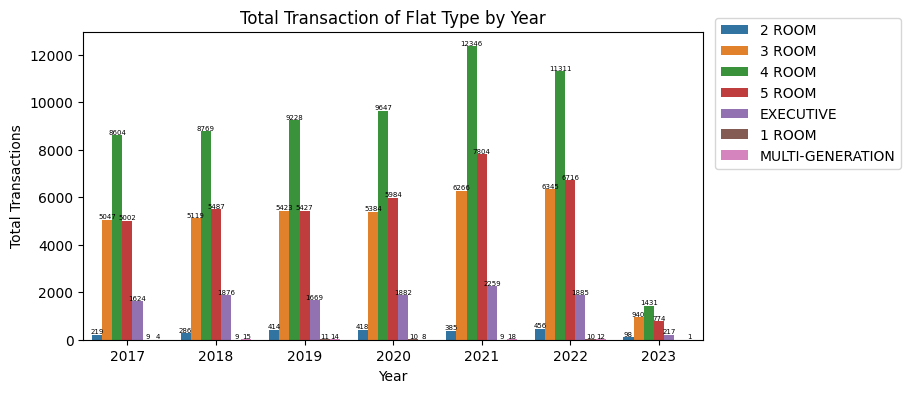

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
flat_type_count = sns.countplot(data=df_resale, x='Tranc_Yr', hue='flat_type')
flat_type_count.legend(loc='right', bbox_to_anchor=(1.33, 0.8), ncol=1)
for container in ax.containers:
    ax.bar_label(container, size=5)
plt.xlabel("Year")
plt.ylabel("Total Transactions")
plt.title("Total Transaction of Flat Type by Year")

plt.show()

- Nhu cầu bán lại tăng đều qua các năm.

- Căn hộ Four, Five và Executive giảm nhẹ trong năm 2022.

#### Count Plot by Month in 2022

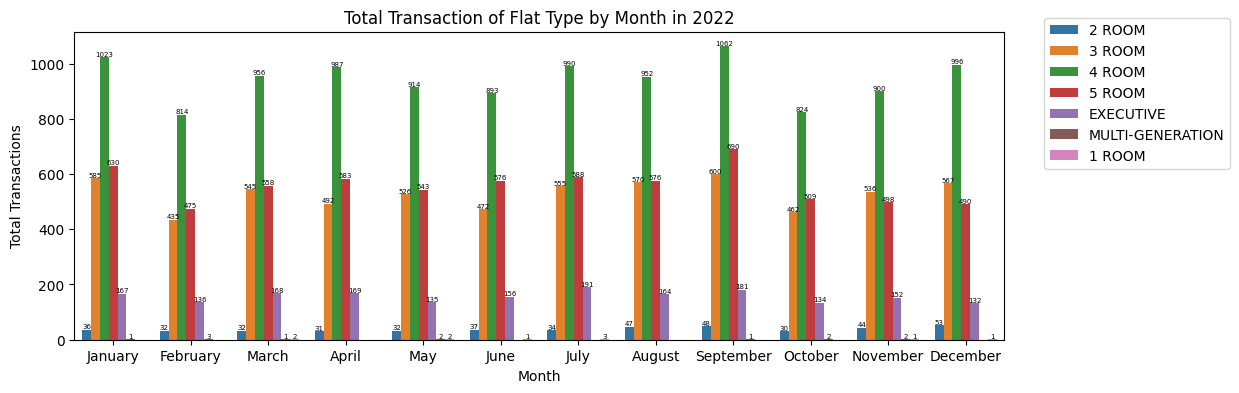

In [31]:
# Countplot of resale by month in the year 2022
fig, ax = plt.subplots(figsize=(12,4))
sale_2022 = df_resale[df_resale['Tranc_Yr'] == 2022]
sale_2022_countplot = sns.countplot(data=sale_2022, x='Tranc_Mth', hue='flat_type')
sale_2022_countplot.legend(loc='right', bbox_to_anchor=(1.25, 0.8), ncol=1)
for container in ax.containers:
    ax.bar_label(container, size=5)
plt.xlabel("Month")
plt.ylabel("Total Transactions")
plt.title("Total Transaction of Flat Type by Month in 2022")

plt.show()

- Năm 2022, các tháng 1, 4, 7, 9, 12 có lượng giao dịch cao hơn so với các tháng khác. Ngoài ra, nhu cầu căn hộ bán lại khá ổn định trong suốt cả năm.

#### Median Resale Price by Year

In [32]:
yearly_med_price = df_resale.groupby(['Tranc_Yr', 'flat_type'])['resale_price'].median().round()
yearly_med_price = pd.DataFrame(yearly_med_price).reset_index()

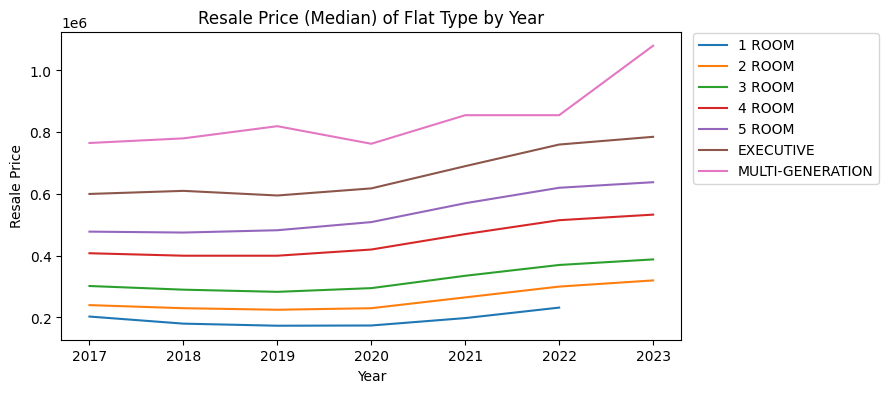

In [33]:
fig, ax = plt.subplots(figsize=(8,4))
yr_med_price = sns.lineplot(data=yearly_med_price, x='Tranc_Yr', y='resale_price', hue='flat_type')
yr_med_price.legend(loc='right', bbox_to_anchor=(1.33, 0.75), ncol=1)

plt.xlabel("Year")
plt.ylabel("Resale Price")
plt.title("Resale Price (Median) of Flat Type by Year")

plt.show()

- Nhìn chung, giá các căn hộ đều tăng ổn định kể từ năm 2017.
- Căn hộ Mult-Gen có mức giá lên xuống thất thường. Tuy nhiên, vào năm 2023, giá trung bình của nó đã tăng vọt vượt qua 1 triệu SGD.
- [Article on "Yishun multi-gen flat sold for new record price of SGD1.08m" - asiaone.com](https://www.asiaone.com/money/yishun-multi-gen-flat-sold-new-record-price-108m)

#### Resale Price (Median) by Floor Area

In [34]:
# Median Resale Price of Flat Type by Floor Area
flr_area_avgprice = df_resale.groupby(['floor_area_sqm', 'flat_type'])['resale_price'].median().round()
flr_area_avgprice = pd.DataFrame(flr_area_avgprice).reset_index()

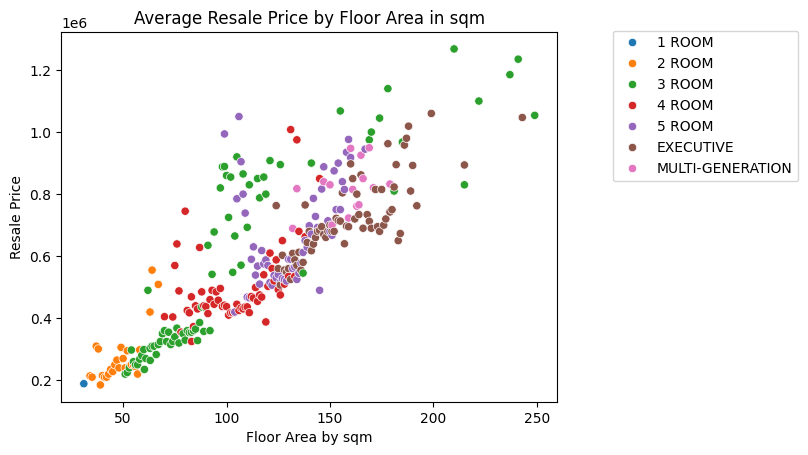

In [35]:
yflr_area_price = sns.scatterplot(data=flr_area_avgprice, x='floor_area_sqm', y='resale_price', hue='flat_type')
yflr_area_price.legend(loc='right', bbox_to_anchor=(1.5, 0.8), ncol=1)
plt.xlabel("Floor Area by sqm")
plt.ylabel("Resale Price")
plt.title("Average Resale Price by Floor Area in sqm")

plt.show()

**Notes:**

1. Nhìn chung, diện tích sàn/m2 rất phù hợp với giá bán lại. Những căn hộ từ 3 đến 5 phòng có diện tích sàn lớn hơn là các mẫu Terrace, Adjoined, Maisonette và Premium Loft. Đây là những mẫu độc đáo và tầm giá thường cao hơn những mẫu thông thường.

2. Loại căn hộ 3 phòng có thể được dự đoán dưới 100m2. Phân bổ giá cho Ba Phòng lớn hơn sẽ phân tán hơn.

3. Khoảng giá loại căn hộ 4 phòng được phân bổ cho diện tích sàn nhỏ hơn và diện tích sàn lớn hơn. Điều này có lẽ bị ảnh hưởng bởi các căn hộ BTO mới hơn (kích thước nhỏ hơn) và Lofts & Terraces (kích thước lớn hơn)

4. Loại căn hộ Five Room có xu hướng khá giống với loại căn hộ 4 Room

5. Dựa trên biểu đồ phân tán, mô hình hồi quy tuyến tính đơn giản sẽ không thể dự đoán tốt vì mô hình phẳng sẽ dịch chuyển giá bán lại từ đường hồi quy thông thường; tạo ra sự chênh lệch giá lớn khi chúng tôi dự đoán.

### Simple Regression vs Polynomial Regression Plot

#### 3 Room Flat Type

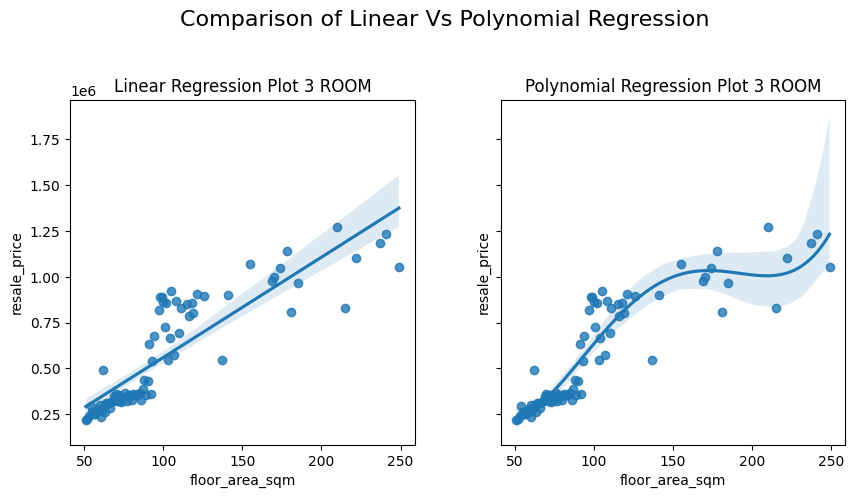

In [36]:
#create a 3 room linear and polynomial regplot
Three_flr_price = flr_area_avgprice[flr_area_avgprice['flat_type']=='3 ROOM']

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
three_room_slr = sns.regplot(x='floor_area_sqm', y='resale_price', data=Three_flr_price, ax=ax1)
three_room_poly = sns.regplot(x='floor_area_sqm', y='resale_price', data=Three_flr_price, order=4, ax=ax2)
three_room_slr.set_title('Linear Regression Plot 3 ROOM')
three_room_poly.set_title('Polynomial Regression Plot 3 ROOM')
fig.suptitle('Comparison of Linear Vs Polynomial Regression', fontsize = 16)
plt.subplots_adjust(top=0.8, wspace=0.25)

plt.show()

##### 4 Room Flat Type

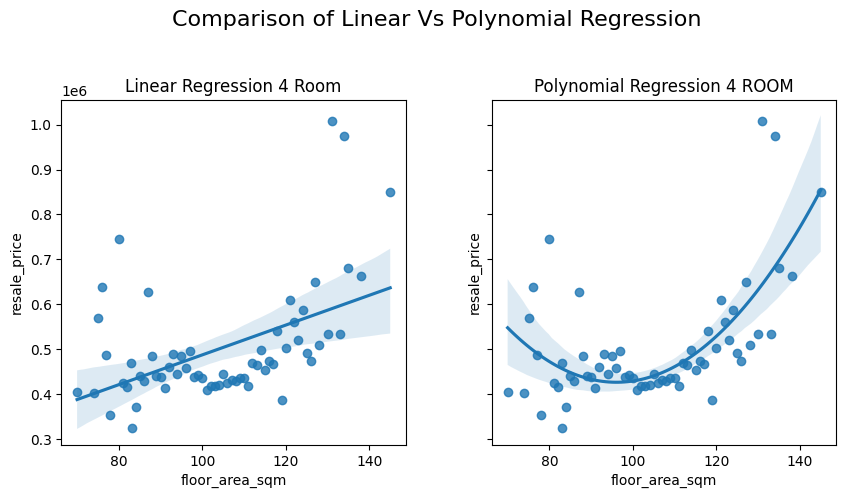

In [37]:
# Creating a four room linear & polynomial regplot
Four_flr_price = flr_area_avgprice[flr_area_avgprice['flat_type']=='4 ROOM']

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
four_room_slr = sns.regplot(data=Four_flr_price, x='floor_area_sqm', y='resale_price', ax=ax1)
four_room_poly = sns.regplot(x='floor_area_sqm', y='resale_price', data=Four_flr_price, order=2, ax=ax2)

four_room_slr.set_title('Linear Regression 4 Room')
four_room_poly.set_title('Polynomial Regression 4 ROOM')
fig.suptitle('Comparison of Linear Vs Polynomial Regression', fontsize = 16)
plt.subplots_adjust(top=0.8, wspace=0.25)

plt.show()

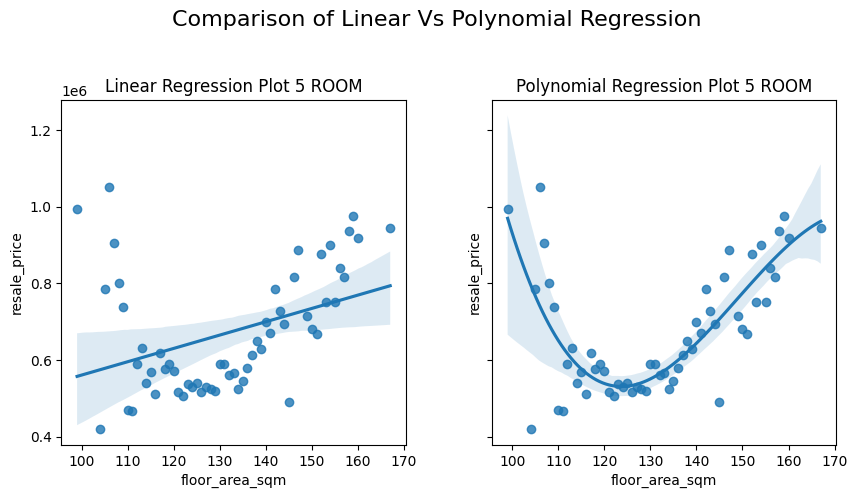

In [38]:
### create a 5 room polynomial regplot
Five_flr_price = flr_area_avgprice[flr_area_avgprice['flat_type']=='5 ROOM']

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
five_room_slr = sns.regplot(x='floor_area_sqm', y='resale_price', data=Five_flr_price, ax=ax1)
five_room_poly = sns.regplot(x='floor_area_sqm', y='resale_price', data=Five_flr_price, order=3, ax=ax2)
five_room_slr.set_title('Linear Regression Plot 5 ROOM')
five_room_poly.set_title('Polynomial Regression Plot 5 ROOM')
fig.suptitle('Comparison of Linear Vs Polynomial Regression', fontsize = 16)
plt.subplots_adjust(top=0.8, wspace=0.25)

plt.show()

Như chúng ta có thể thấy từ sơ đồ hồi quy 3 Phòng, 4 Phòng và 5 Phòng, hồi quy đơn giản sẽ khó có được dự đoán tốt ngay cả khi thêm chức năng giảm độ dốc.

**Câu hỏi đặt ra là:** Liệu chúng có phù hợp quá mức với mô hình hồi quy đa thức không?

Vấn đề nan giải của việc giảm phương sai và giảm sai lệch

### Using CPI Adjusted for Modeling

Let's see if there will be bigger or smaller variances if we use Adjusted Price instead

In [39]:
flr_area_avg_ap = df_resale.groupby(['floor_area_sqm', 'flat_type'])['Adjusted_Price'].median().round()
flr_area_avg_ap = pd.DataFrame(flr_area_avg_ap).reset_index()

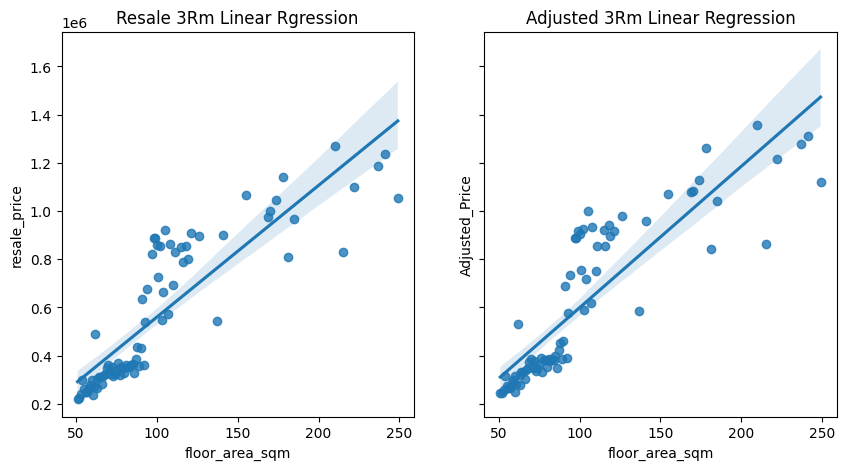

In [40]:
#create a 3 room linear and polynomial regplot
Three_flr_ap = flr_area_avg_ap[flr_area_avg_ap['flat_type']=='3 ROOM']

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
three_room_slr = sns.regplot(x='floor_area_sqm', y='resale_price', data=Three_flr_price, ax=ax1)
three_room_ap_slr = sns.regplot(x='floor_area_sqm', y='Adjusted_Price', data=Three_flr_ap, ax=ax2)
three_room_slr.set_title('Resale 3Rm Linear Rgression')
three_room_ap_slr.set_title('Adjusted 3Rm Linear Regression')

plt.show()

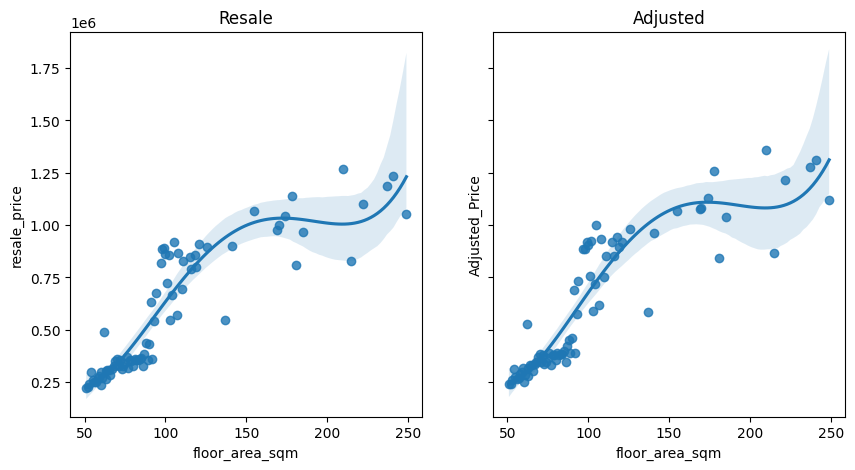

In [41]:
#Comparing Adjust_price vs Resale Price 3 Room
Three_flr_ap = flr_area_avg_ap[flr_area_avg_ap['flat_type']=='3 ROOM']

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
resale_three_room = sns.regplot(x='floor_area_sqm', y='resale_price', data=Three_flr_price, order =4 ,ax=ax1)
adjusted_three_room = sns.regplot(x='floor_area_sqm', y='Adjusted_Price', data=Three_flr_ap, order=4, ax=ax2)
resale_three_room.set_title('Resale')
adjusted_three_room.set_title('Adjusted')

plt.show()

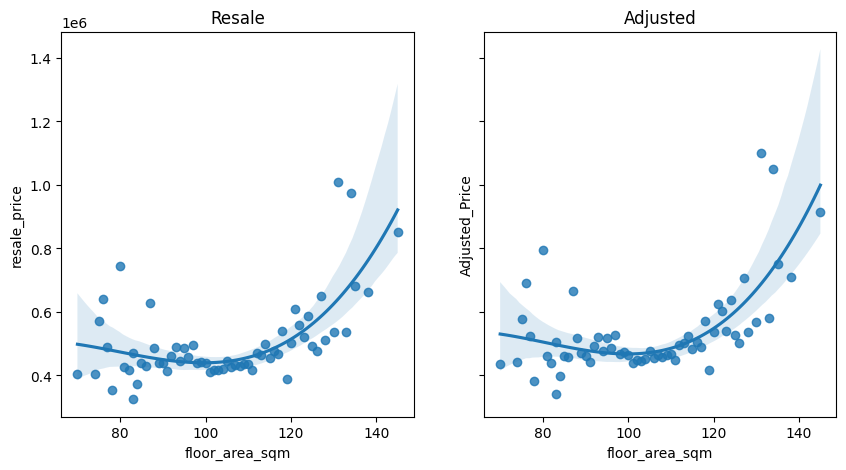

In [42]:
#Comparing Adjust_price vs Resale Price 4 Room
Four_flr_ap = flr_area_avg_ap[flr_area_avg_ap['flat_type']=='4 ROOM']

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
resale_four_room = sns.regplot(x='floor_area_sqm', y='resale_price', data=Four_flr_price, order = 3 ,ax=ax1)
adjusted_four_room = sns.regplot(x='floor_area_sqm', y='Adjusted_Price', data=Four_flr_ap, order = 3, ax=ax2)
resale_four_room.set_title('Resale')
adjusted_four_room.set_title('Adjusted')

plt.show()

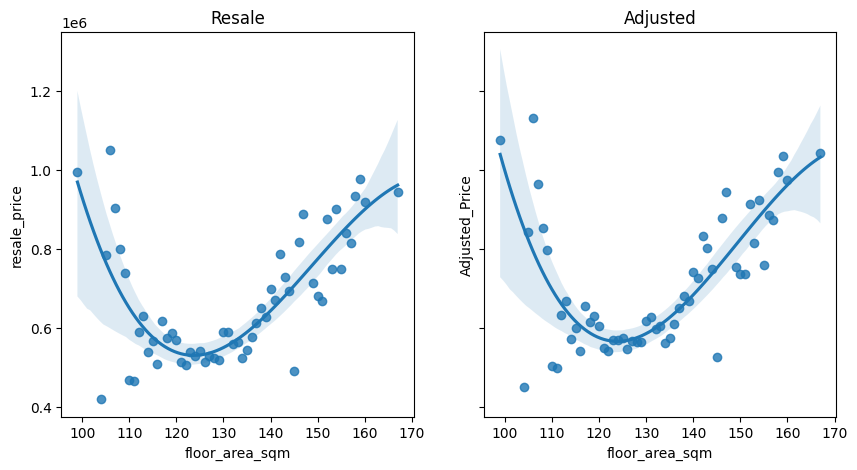

In [43]:
#Comparing Adjust_price vs Resale Price 4 Room
Five_flr_ap = flr_area_avg_ap[flr_area_avg_ap['flat_type']=='5 ROOM']

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
resale_five_room = sns.regplot(x='floor_area_sqm', y='resale_price', data=Five_flr_price, order = 3 ,ax=ax1)
adjusted_five_room = sns.regplot(x='floor_area_sqm', y='Adjusted_Price', data=Five_flr_ap, order = 3, ax=ax2)
resale_five_room.set_title('Resale')
adjusted_five_room.set_title('Adjusted')

plt.show()

**Note:**

Khi so sánh song song, có vẻ như việc sử dụng Giá bán lại đã điều chỉnh CPI (Giá_điều chỉnh) có thể có lợi hơn một chút trong việc xây dựng mô hình dự đoán. Khi cân nhắc điều đó, tôi sẽ sử dụng Giá_điều chỉnh làm kết quả dự đoán.

## Predictive Model: Setting the Baseline Using Linear Regression

### Linear Regression for the first Baseline
_____________________________________

Sau đây là cách tiếp cận của tôi để dự đoán và so sánh mô hình hồi quy:

1. Chia tập dữ liệu theo loại phẳng.
2. Tạo DataFrame riêng cho từng loại phẳng.
3. Xây dựng mô hình với Hồi quy tuyến tính để lấy điểm cơ bản cho từng loại phẳng.
4. Xây dựng thêm hai mô hình với (a) Bộ hồi quy RandomForest (b) Bộ hồi quy XGB.
5. So sánh và chọn ra mô hình tốt nhất.

------------------

In [60]:
# Change flat_type values and dtype to category

def change_flat_type(df):
    df['flat_type'] = df['flat_type'].replace({'1 ROOM': 'ONE_ROOM',
                                                '2 ROOM': 'TWO_ROOM',
                                                '3 ROOM': 'THREE_ROOM',
                                                '4 ROOM': 'FOUR_ROOM',
                                                '5 ROOM': 'FIVE_ROOM'}).astype('category')
    return df

df_resale = change_flat_type(df_resale)


In [66]:
#Change flat_model and town to dtype category
df_resale['flat_model'] = df_resale.flat_model.astype('category')
df_resale['town'] = df_resale.town.astype('category')

In [67]:
# Reduced Adjusted and Resale Price by 1000
df_resale['Adjusted_Price'] = df_resale['Adjusted_Price'] / 1000
df_resale

Tranc_Yr Tranc_Mth        town   flat_type      flat_model  \
0           2017   January  ANG MO KIO    TWO_ROOM        Improved   
1           2017   January  ANG MO KIO  THREE_ROOM  New Generation   
2           2017   January  ANG MO KIO  THREE_ROOM  New Generation   
3           2017   January  ANG MO KIO  THREE_ROOM  New Generation   
4           2017   January  ANG MO KIO  THREE_ROOM  New Generation   
...          ...       ...         ...         ...             ...   
146867      2023  February      YISHUN   FIVE_ROOM        Improved   
146868      2023  February      YISHUN   FIVE_ROOM        Improved   
146869      2023  February      YISHUN   EXECUTIVE       Apartment   
146870      2023  February      YISHUN   EXECUTIVE      Maisonette   
146871      2023  February      YISHUN   EXECUTIVE       Apartment   

        median_flr  Distance_from_CBD  remaining_yr  floor_area_sqm  \
0               11       15219.866341     61.333333            44.0   
1                2       15219.866341     60.583333            67.0   
2                2       15210.637211     62.416667            67.0   
3                5       15219.866341     62.083333            68.0   
4                2       15219.866341     62.416667            67.0   
...            ...                ...           ...             ...   
146867           2       15219.866341     64.083333           127.0   
146868          11       15219.866341     64.166667           122.0   
146869           8       15219.866341     68.416667           181.0   
146870          11       15219.866341     64.833333           146.0   
146871           2       15219.866341     63.333333           142.0   

        resale_price  Adjusted_Price  
0           232000.0    2.380000e-07  
1           250000.0    2.564000e-07  
2           262000.0    2.687000e-07  
3           265000.0    2.718000e-07  
4           265000.0    2.718000e-07  
...              ...             ...  
146867      700000.0    7.000000e-07  
146868      700000.0    7.000000e-07  
146869     1068000.0    1.068000e-06  
146870      838000.0    8.380000e-07  
146871      765000.0    7.650000e-07  

[146872 rows x 11 columns]

In [47]:
# Get unique values in the column 'flat_type' and convert into dictionary call dfs 

def unique_flat_types(df):
    unique_flat_types = df['flat_type'].unique()
    return unique_flat_types

def create_flat_dict(df):
    unique_types = unique_flat_types(df)
    dfs = {flat_type: df[df['flat_type'] == flat_type] for flat_type in unique_types}
    return dfs

dfs = create_flat_dict(df_resale)

In [48]:
#Convert Dictionary to Dataframe

def create_flat_dfs(flat_dict):
    flat_types = list(flat_dict.keys())
    for flat_type in flat_types:
        df = pd.DataFrame(flat_dict[flat_type])
        globals()[flat_type] = df
        print(flat_type + ' DataFrame created successfully')

create_flat_dfs(dfs)

TWO_ROOM DataFrame created successfully
THREE_ROOM DataFrame created successfully
FOUR_ROOM DataFrame created successfully
FIVE_ROOM DataFrame created successfully
EXECUTIVE DataFrame created successfully
ONE_ROOM DataFrame created successfully
MULTI-GENERATION DataFrame created successfully


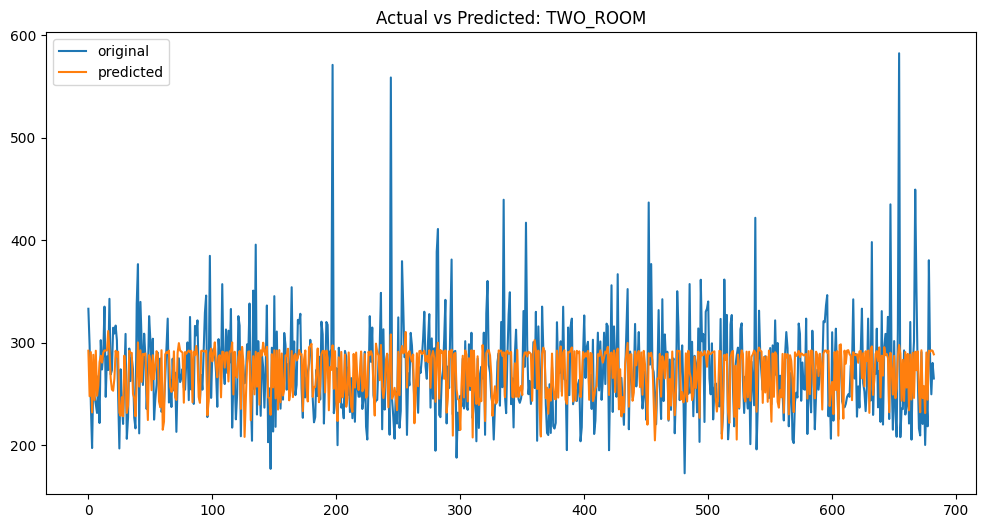

/n
Scores for TWO_ROOM
R2 Score: 0.25296029736232817
MSE Score: 1644.3942989455845
RMSE Score: 40.55113190708226
MAE Score: 29.85805730017275 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count        683.00           683.00            683.00        683.00
mean         272.46           271.65             -0.81          1.56
std           46.95            23.55             40.59         13.35
min          172.70           205.00           -284.20        -48.81
25%          241.20           248.50            -23.80         -7.99
50%          265.50           287.00              4.10          1.44
75%          297.40           291.00             26.30         10.77
max          582.20           311.00             82.80         43.60

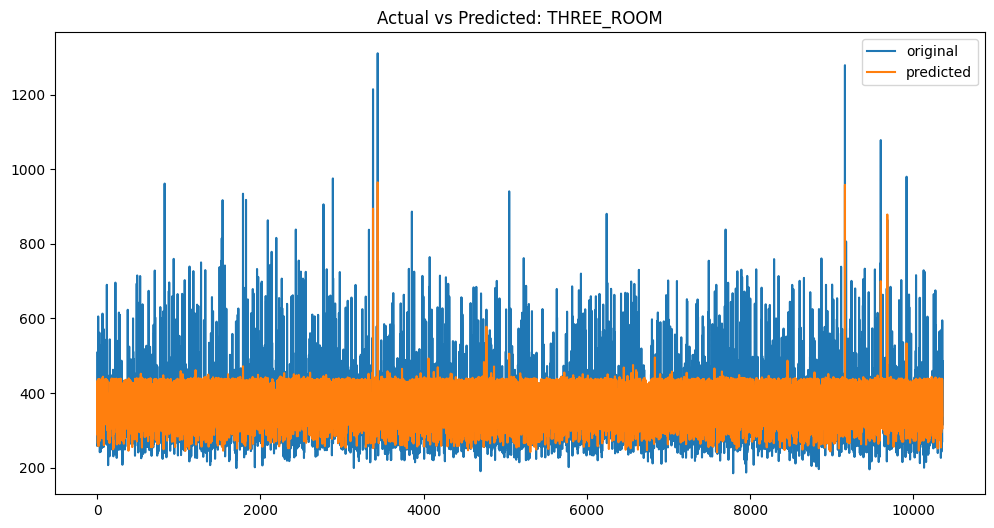

/n
Scores for THREE_ROOM
R2 Score: 0.28851951042524027
MSE Score: 5551.576824866248
RMSE Score: 74.50890433274569
MAE Score: 54.06225908646241 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      10358.00         10358.00          10358.00      10358.00
mean         355.86           356.00              0.14          3.46
std           88.34            47.92             74.51         18.41
min          184.80           241.00           -574.70        -59.58
25%          297.60           325.00            -32.90         -8.79
50%          340.10           347.00             10.15          2.96
75%          389.50           384.00             49.97         16.23
max         1311.40           965.00            161.20         87.23

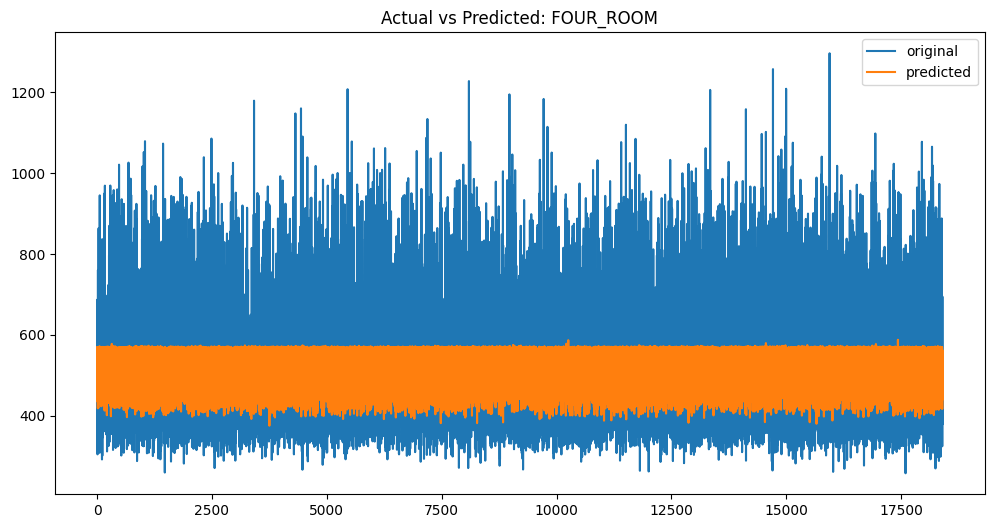

/n
Scores for FOUR_ROOM
R2 Score: 0.12845017642221723
MSE Score: 16482.474529178548
RMSE Score: 128.38408985999217
MAE Score: 96.82733711529798 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      18401.00         18401.00          18401.00      18401.00
mean         506.37           505.46             -0.91          5.22
std          137.52            50.02            128.39         23.00
min          257.60           375.00           -754.70        -63.65
25%          414.80           460.00            -53.30         -9.94
50%          475.00           506.00             25.60          5.33
75%          556.60           560.00             89.00         20.87
max         1296.70           588.00            228.40         81.98

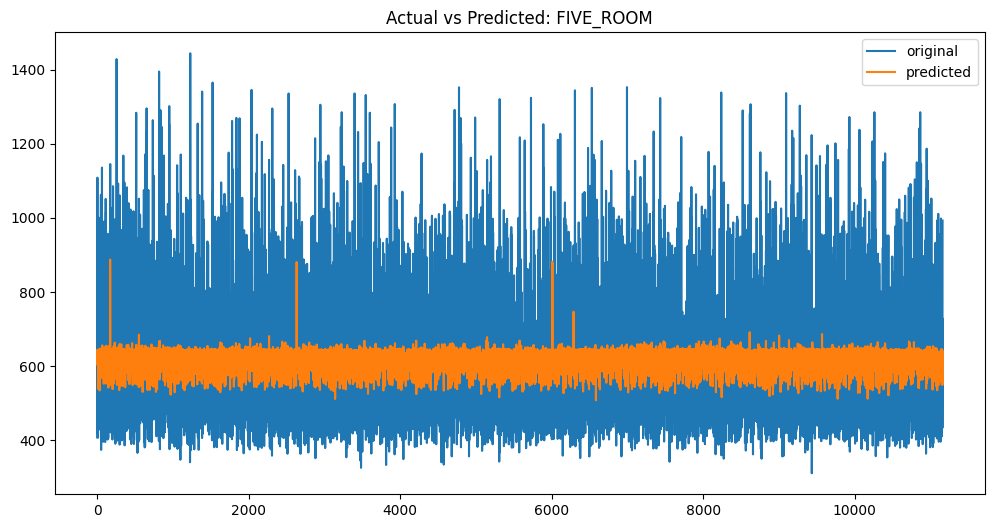

/n
Scores for FIVE_ROOM
R2 Score: 0.023986864116391393
MSE Score: 25887.05861668014
RMSE Score: 160.89455744890856
MAE Score: 122.98742965742356 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      11159.00         11159.00           11159.0      11159.00
mean         609.50           610.50               1.0          6.26
std          162.87            25.68             160.9         24.38
min          311.40           508.00            -836.0        -57.89
25%          492.90           596.00             -70.7        -10.30
50%          573.10           610.00              36.2          6.33
75%          683.50           629.00             118.0         23.95
max         1444.00           888.00             346.4         91.60

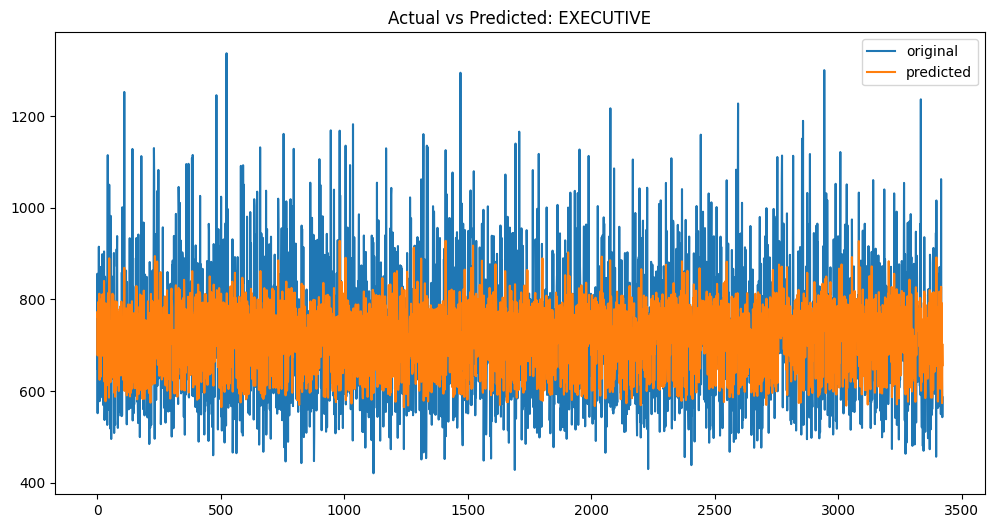

/n
Scores for EXECUTIVE
R2 Score: 0.25876548989010717
MSE Score: 13757.852574369015
RMSE Score: 117.29387270599013
MAE Score: 89.94247066440482 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count       3424.00          3424.00           3424.00       3424.00
mean         717.03           718.46              1.43          2.70
std          136.26            69.39            117.30         15.87
min          420.50           565.00           -580.00        -43.38
25%          614.38           667.00            -60.15         -7.76
50%          698.55           727.00             13.80          1.93
75%          799.40           772.25             81.90         13.03
max         1337.00           928.00            347.00         73.36

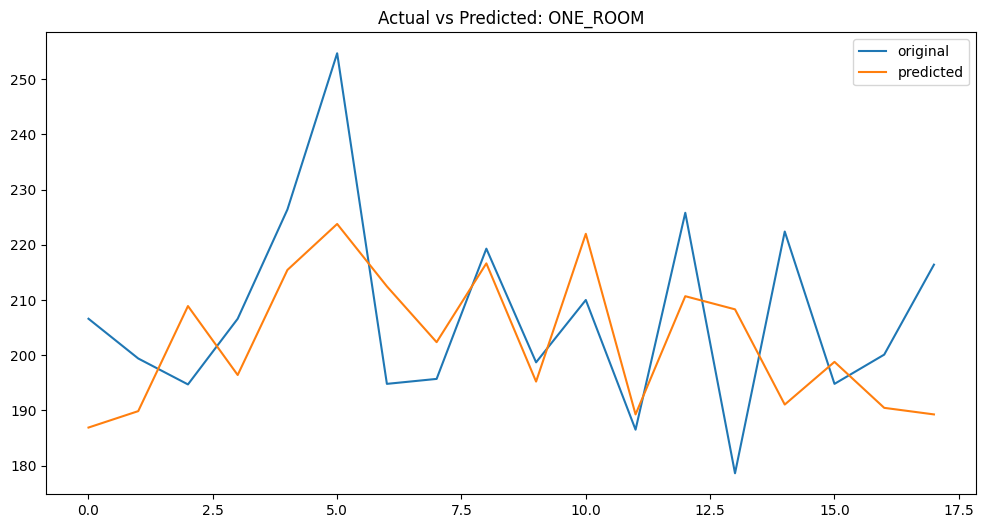

/n
Scores for ONE_ROOM
R2 Score: 0.025544716851495397
MSE Score: 295.9783108075155
RMSE Score: 17.20402019318495
MAE Score: 14.316282544895424 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         18.00            18.00             18.00         18.00
mean         207.31           202.56             -4.75         -1.81
std           17.93            12.38             16.98          8.17
min          178.60           187.00            -31.40        -14.12
25%          195.02           190.25            -13.95         -6.20
50%          203.35           200.50             -6.55         -3.29
75%          218.58           211.75              5.78          2.95
max          254.70           224.00             29.40         16.46

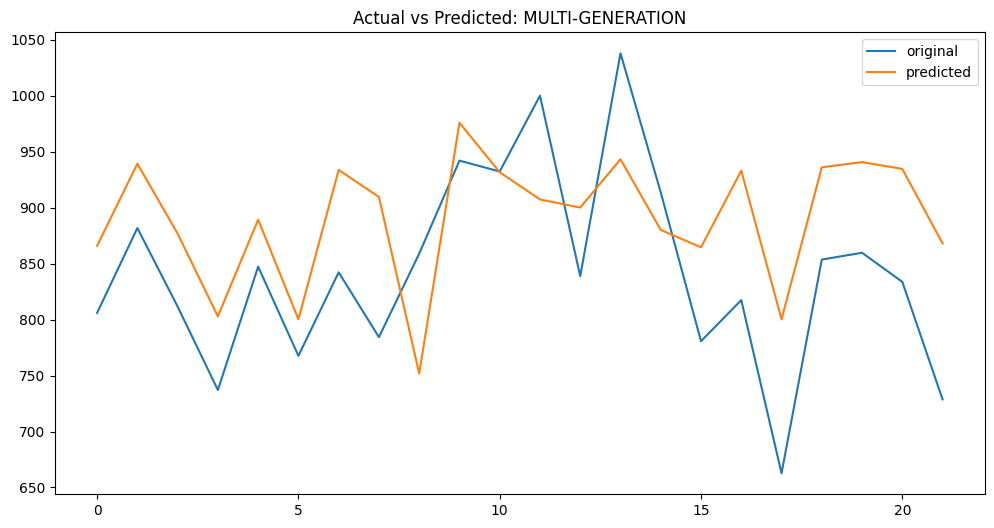

/n
Scores for MULTI-GENERATION
R2 Score: 0.00503790123614023
MSE Score: 7257.546959417388
RMSE Score: 85.19123757416246
MAE Score: 77.45750775422725 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         22.00            22.00             22.00         22.00
mean         842.63           890.27             47.64          6.33
std           87.42            57.92             72.40          8.79
min          662.70           752.00           -106.90        -12.45
25%          789.72           866.50             32.80          3.76
50%          840.50           903.50             63.30          7.75
75%          876.28           934.75             89.92         10.87
max         1037.90           976.00            139.30         20.72



CPU times: total: 1.09 s
Wall time: 1.53 s


In [50]:
%%time

def linear_regression(flat_type):
    # Extract the data for each flat_type
    data = dfs[flat_type]
    
    
    # Extract the data for each flat_type
    features = ['Tranc_Yr', 'Tranc_Mth', 'median_flr', 'town', 'flat_model', 'Distance_from_CBD', 'remaining_yr', 'floor_area_sqm']
    
    # Define X and y
    X = data.loc[:, features]
    y = data.loc[:, 'Adjusted_Price']
    
    # Pipeline KNN to handle null values and outliers and StandardScaler numerical columns
    num_trans = make_pipeline(KNNImputer(n_neighbors=10), 
                                StandardScaler())
    
    cat_trans = make_pipeline(OneHotEncoder())
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Creating the numerical and categorical columns
    
    cat_cols = [cname for cname in X.columns if X[cname].dtype == ['object', 'category']]
    num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

    # set up the column transformer to apply OneHotEncoder and StandardScaler
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('cat', cat_trans, cat_cols),
                        ('Std', num_trans, num_cols)])
    
    #Instantiation: Linear Regression
    linreg = LinearRegression()
    
    # set up the pipeline with the column transformer and the linear regression model
    
    pipeline_lr = Pipeline([('preprocessor', preprocessor),
                        ('model', linreg)])
    
    # Fit the linear regression model
    pipeline_lr.fit(X_train, y_train)
    
    #Scoring
    y_pred = pipeline_lr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae= mean_absolute_error(y_test, y_pred)
    score = pipeline_lr.score(X_test, y_test)
    
    #Plot Graph
    fig, ax = plt.subplots(figsize=(12,6))
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("Actual vs Predicted: {}".format(flat_type))
    plt.legend()
    plt.show()
    
    print("/n")
    print('Scores for {}'.format(flat_type))
    print('R2 Score:', score)
    print('MSE Score:', mse)
    print('RMSE Score:', rmse)
    print('MAE Score:', mae, '\n')
    
    #get Actual and Predicted df
    compare = pd.DataFrame({'Actual (000)': y_test, 'Predicted (000)': y_pred})
    
    #Apply Function to round off to nearest 1000
    
    compare['Predicted (000)'] = round(compare['Predicted (000)'])


    #Get Dataframe to show the price diff between Actual and Predicted
    compare['Price Diff (000)'] = compare['Predicted (000)'] - compare['Actual (000)']
    compare['Percent Diff'] = (compare['Predicted (000)'] - compare['Actual (000)']) / compare['Actual (000)'] *100
    
    compare_styled = compare.head(30).style.format('{:.1f}', na_rep="")\
    .bar(subset=['Percent Diff'], color='#01C6BA', align='zero')
    
    display(compare_styled)
    print('\n')
    display(compare.describe().round(2))
    print('\n')

    
#Apply the function to each flat_type

for flat_type in dfs.keys():
    linear_regression(flat_type)

**Summary Baseline Scoring for All Flat Types**

| Flat Type  | 1 Room | 2 Room | 3 Room | 4 Room | 5 Room | Executive | Multi-Gen |
|------------|--------|--------|--------|--------|--------|-----------|-----------|
| R^2 Score  |  0.10  | 0.54   | 0.66   | 0.75   | 0.72   | 0.64      | 0.66      |
| Min % Diff | -12.45 | -44.86 | -58.72 | -50.91 | -49.46 | -33.95    | -14.19    |
| Max % Diff |  15.34 | 41.41  | 96.97  | 57.66  | 59.89  | 51.02     |  11.67    |

From the above summary,

**One ROOM**
- It is understandable that 1 Room R^2 score is very low because it is based on 1 block of flats and prices are very widely distributed and only 58 transactions in the last 6 years.

**Two ROOM**
- Two room prediction is within range when it comes to those within Q1 to Q3. However, it fails to predict those with higher price Q4. 

**Three ROOM**
- Similar to two room flat type, Q4 prediction is not very accurate. However, it did pick up a few exceptionally high prices one.
- Three Room has the widest Percentage Difference in price as expected, from the earlier scatterplot visualization.

**Four ROOM**
- Four Room misses most of the Q4 and also it predicted lower price for Q1.
- It is also noted that four room flat type has the most transaction. With more data points, the ML model learns better and thus produced the highest R^2 scores when compared to other room types.

**Five ROOM**
- Five Room has a few misses and hits. Slightly better in their R^2 score however they also have a wide Percentage Difference.

**Executive & Multi-Gen**
- Both flat types perform average scores in their prediction. 

This baseline model performs very efficiently with total CPU time of 6.71secs. 
_____________________
 
#### Suggestion for Improvement:

**1. Bagging / Bootstrapping**
- Using RandomForestRegressor with Boostrap as hyperparameter. 

**2. Gradient Boosting** 
- Using XGBRegressor with parameters for optimized result.



## Model Comparison

### RandomForestRegressor

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


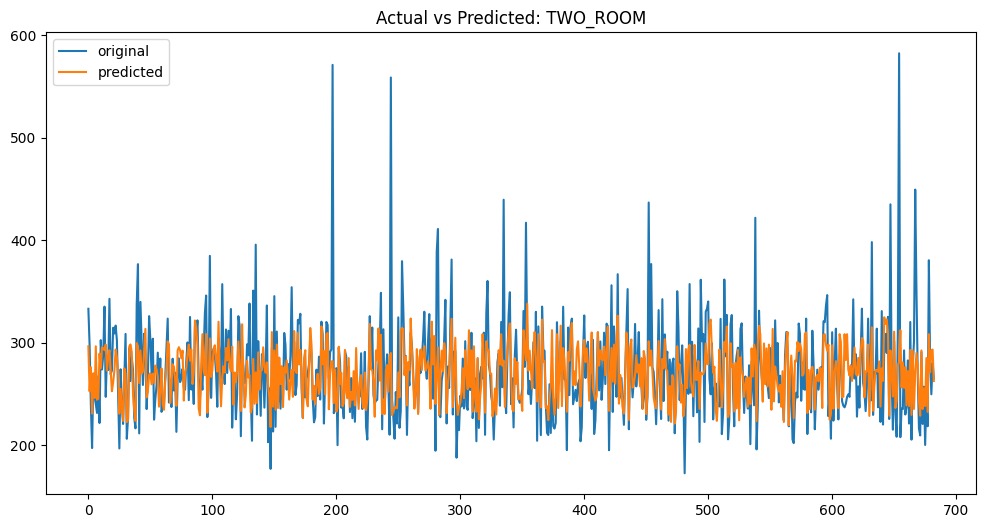



Scores for TWO_ROOM
R2 Score: 0.3188964729664079
MSE Score: 1499.2546619560208
RMSE Score: 38.72020999369736
MAE Score: 26.33261950001755 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count        683.00           683.00            683.00        683.00
mean         272.46           270.41             -2.05          0.90
std           46.95            25.73             38.69         12.27
min          172.70           218.00           -300.20        -51.56
25%          241.20           247.00            -17.90         -6.38
50%          265.50           272.00              0.90          0.30
75%          297.40           292.00             20.10          8.32
max          582.20           338.00            104.10         50.07

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


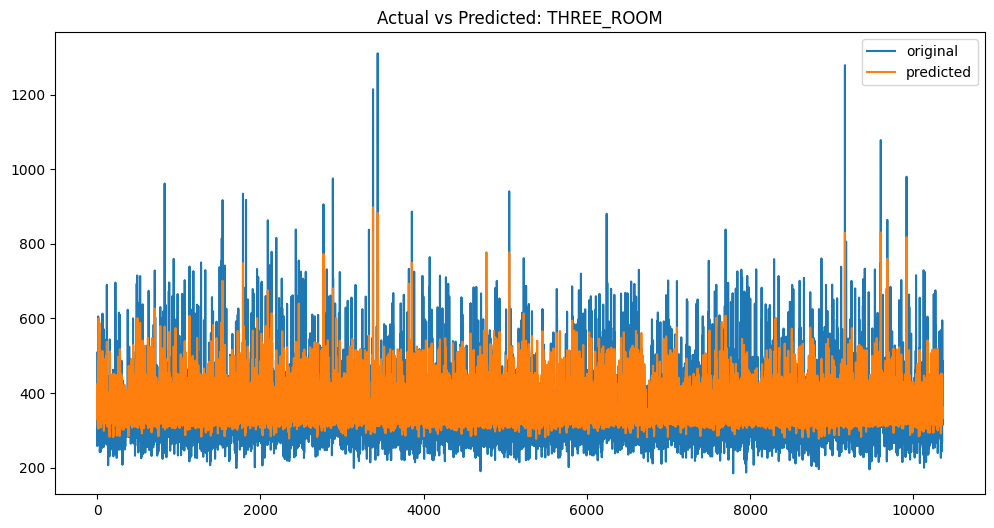



Scores for THREE_ROOM
R2 Score: 0.5134045916215295
MSE Score: 3796.8318623252917
RMSE Score: 61.61843768163302
MAE Score: 45.1676279531187 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      10358.00         10358.00          10358.00      10358.00
mean         355.86           355.85             -0.01          2.88
std           88.34            53.19             61.63         15.92
min          184.80           277.00           -449.40        -48.05
25%          297.60           327.00            -29.50         -7.78
50%          340.10           335.00              7.40          2.20
75%          389.50           363.00             39.80         13.07
max         1311.40           898.00            229.20        124.03

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


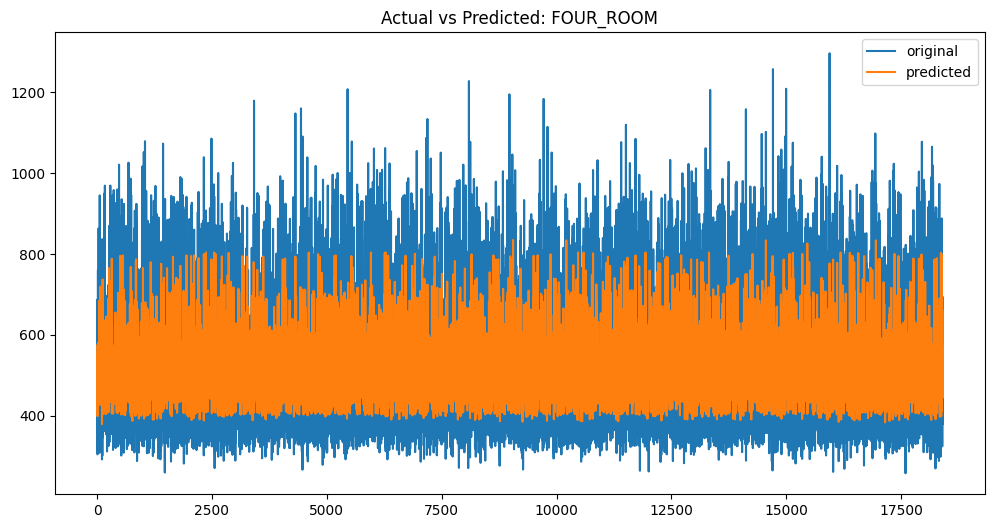



Scores for FOUR_ROOM
R2 Score: 0.3187061210708376
MSE Score: 12884.414295716953
RMSE Score: 113.50953394194231
MAE Score: 82.97297955720357 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      18401.00         18401.00          18401.00      18401.00
mean         506.37           505.20             -1.18          4.21
std          137.52            68.23            113.50         20.10
min          257.60           379.00           -631.90        -52.22
25%          414.80           457.00            -42.80         -7.84
50%          475.00           478.00             20.50          4.33
75%          556.60           554.00             73.20         17.45
max         1296.70           835.00            366.60         92.07

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


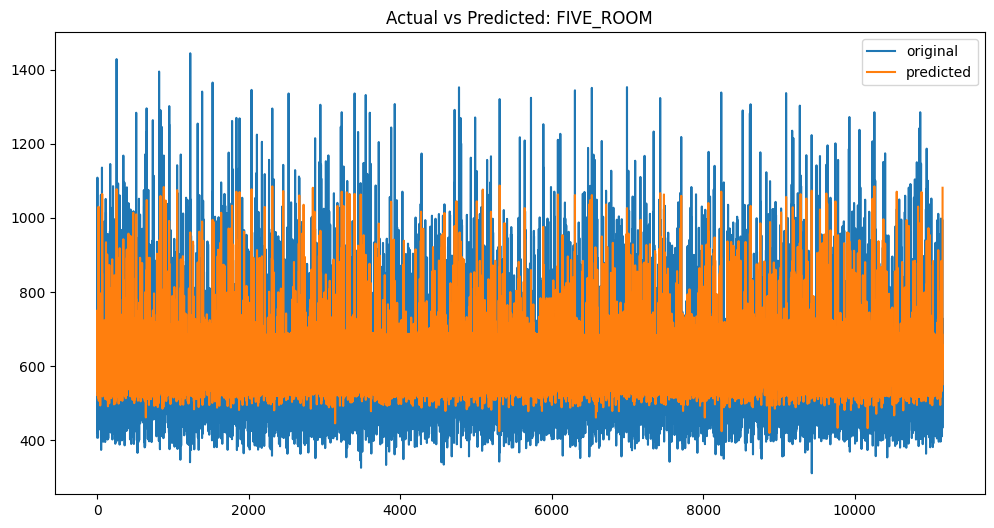



Scores for FIVE_ROOM
R2 Score: 0.3738275984400121
MSE Score: 16608.138832737826
RMSE Score: 128.87256819330415
MAE Score: 94.02157256612755 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      11159.00         11159.00          11159.00      11159.00
mean         609.50           610.19              0.68          4.32
std          162.87            87.97            128.88         19.49
min          311.40           420.00           -653.60        -53.96
25%          492.90           556.00            -44.55         -6.84
50%          573.10           589.00             24.90          4.33
75%          683.50           650.00             82.40         16.29
max         1444.00          1087.00            403.00        112.89

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


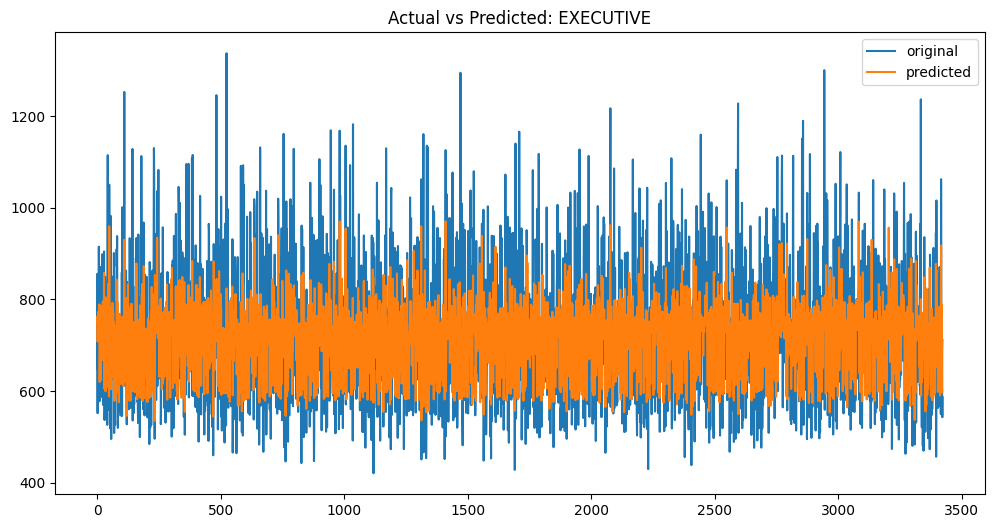



Scores for EXECUTIVE
R2 Score: 0.3190446873333296
MSE Score: 12639.026750134004
RMSE Score: 112.42342616258412
MAE Score: 84.83193734038099 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count       3424.00          3424.00           3424.00       3424.00
mean         717.03           718.10              1.07          2.51
std          136.26            71.68            112.44         15.18
min          420.50           535.00           -530.20        -42.04
25%          614.38           673.00            -56.03         -7.20
50%          698.55           735.00             11.85          1.65
75%          799.40           759.00             72.75         11.74
max         1337.00           970.00            396.00         83.72

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


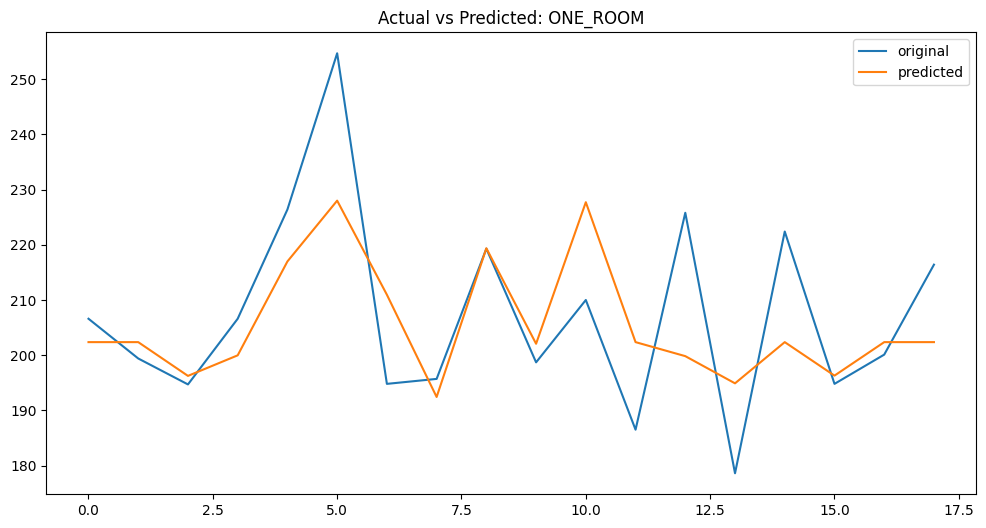



Scores for ONE_ROOM
R2 Score: 0.40200214572134496
MSE Score: 181.63418869672392
RMSE Score: 13.477172874780672
MAE Score: 10.446832429453263 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         18.00            18.00             18.00         18.00
mean         207.31           205.33             -1.97         -0.54
std           17.93            10.78             13.76          6.43
min          178.60           192.00            -26.70        -11.43
25%          195.02           200.00             -8.70         -3.91
50%          203.35           202.00              0.45          0.24
75%          218.58           208.75              3.13          1.57
max          254.70           228.00             18.00          9.18

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


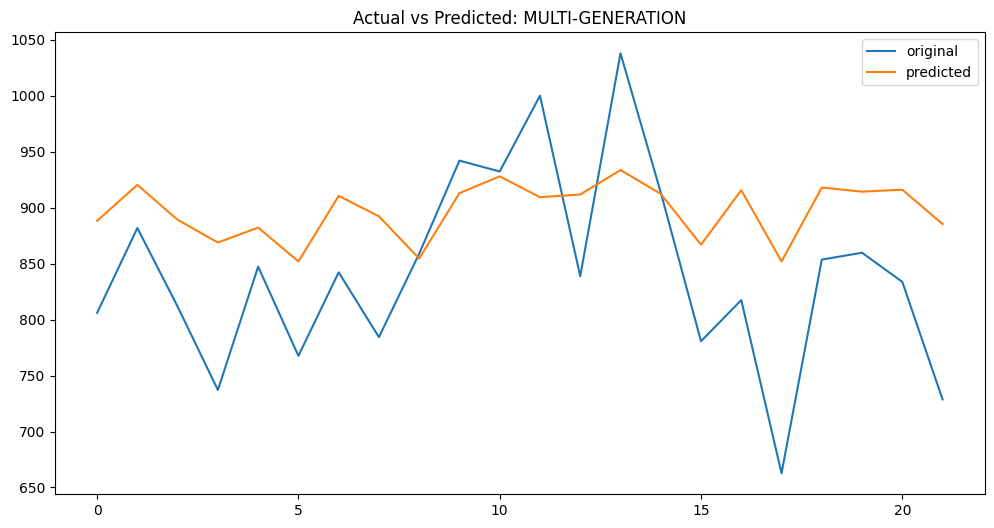



Scores for MULTI-GENERATION
R2 Score: -0.07755901005902688
MSE Score: 7860.033187960431
RMSE Score: 88.65682820832488
MAE Score: 75.64394918831168 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         22.00            22.00             22.00         22.00
mean         842.63           897.00             54.37          7.33
std           87.42            25.25             71.65          9.13
min          662.70           852.00           -103.90        -10.01
25%          789.72           882.75              7.47          0.89
50%          840.50           910.00             71.00          8.45
75%          876.28           915.50             85.82         11.04
max         1037.90           934.00            189.30         28.56



CPU times: total: 1.42 s
Wall time: 2.9 s


In [51]:
%%time

def random_forest_regression(flat_type):
    
    # Extract the data for each flat_type
    data = dfs[flat_type]
    
    
    # Extract the data for each flat_type
    features = ['Tranc_Yr', 'Tranc_Mth', 'median_flr', 'town', 'flat_model', 'Distance_from_CBD', 'remaining_yr', 'floor_area_sqm']
    
    # Define X and y
    X = data.loc[:, features]
    y = data.loc[:, 'Adjusted_Price']
    
    # Pipeline KNN to handle null values and outliers and StandardScaler numerical columns
    num_trans = make_pipeline(KNNImputer(n_neighbors=10), 
                              StandardScaler())
    
    cat_trans = make_pipeline(OneHotEncoder())
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Creating the numerical and categorical columns
    
    cat_cols = [cname for cname in X.columns if X[cname].dtype == ['object', 'category']]
    num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
                  
    # set up the column transformer to apply OneHotEncoder and StandardScaler
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('cat', cat_trans, cat_cols),
                      ('Std', num_trans, num_cols)])
    
    #Instantiation RandomForestRegressor
    rf = RandomForestRegressor(criterion='squared_error', n_estimators=100, min_samples_split=5, n_jobs=3,
                               min_samples_leaf=3, max_depth=13, bootstrap=True, max_samples=0.3, 
                               min_impurity_decrease = 0.1, max_features=0.2, verbose=1, random_state=42)    
    
    # set up the pipeline with the column transformer and the RandomForestRegressor model
    
    pipeline_rf = Pipeline([('preprocessor', preprocessor),
                        ('model', rf)])
    
    # Fit the linear regression model
    pipeline_rf.fit(X_train, y_train)
    
    #Scoring
    y_pred = pipeline_rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae= mean_absolute_error(y_test, y_pred)
    score = pipeline_rf.score(X_test, y_test)
    
    #Plot Graph
    fig, ax = plt.subplots(figsize=(12,6))
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("Actual vs Predicted: {}".format(flat_type))
    plt.legend()
    plt.show()
    
    print('\n')
    print('Scores for {}'.format(flat_type))
    print('R2 Score:', score)
    print('MSE Score:', mse)
    print('RMSE Score:', rmse)
    print('MAE Score:', mae, '\n')
    
    #get Actual and Predicted df
    compare = pd.DataFrame({'Actual (000)': y_test, 'Predicted (000)': y_pred})
    
    #Apply Function to round off to nearest 1000
    
    compare['Predicted (000)'] = round(compare['Predicted (000)'])


    #Get Dataframe to show the price diff between Actual and Predicted
    compare['Price Diff (000)'] = compare['Predicted (000)'] - compare['Actual (000)']
    compare['Percent Diff'] = (compare['Predicted (000)'] - compare['Actual (000)']) / compare['Actual (000)'] *100
    
    compare_styled = compare.head(30).style.format('{:.1f}', na_rep="")\
    .bar(subset=['Percent Diff'], color='#01C6BA', align='zero')
    
    display(compare_styled)
    print('\n')
    display(compare.describe().round(2))
    print('\n')
      
#Apply the function to each flat_type

for flat_type in dfs.keys():
    random_forest_regression(flat_type)

**Score Observation:**

| Model       | 1 Room | 2 Room | 3 Room | 4 Room | 5 Room | Executive | Multi-Gen |
|-------------|--------|--------|--------|--------|--------|-----------|-----------|
| **Linear Regression**  | 
| R^2 Score   |  0.10  | 0.54   | 0.66   | 0.75   | 0.72   | 0.64      | 0.66      |
| **RandomForest Regression** | 
| R^2 Score   |  0.39  | 0.71   | 0.88   | 0.91   | 0.90   | 0.82      | 0.17      |
|             |        |        |        |        |        |           |           |

**Hyperparameter:** *criterion='squared_error', n_estimators=100, min_samples_split=5, n_jobs=3,
                   min_samples_leaf=3, max_depth=13, bootstrap=True, max_samples=0.3, 
                        min_impurity_decrease = 0.1, max_features ='auto', verbose=1, random_state=42*
                        
- Overall all except Multi-Gen R^2 score improved. 
- Even with Bootstrapping, Multi-Gen performs worse with only 0.17 R^2 score.
- One Room though inproved still does not predict well. 

The model took total of CPU time of 19.1 secs to complete.

### XGBoost Regressor

Let's see using XGBRegressor will give us a better score

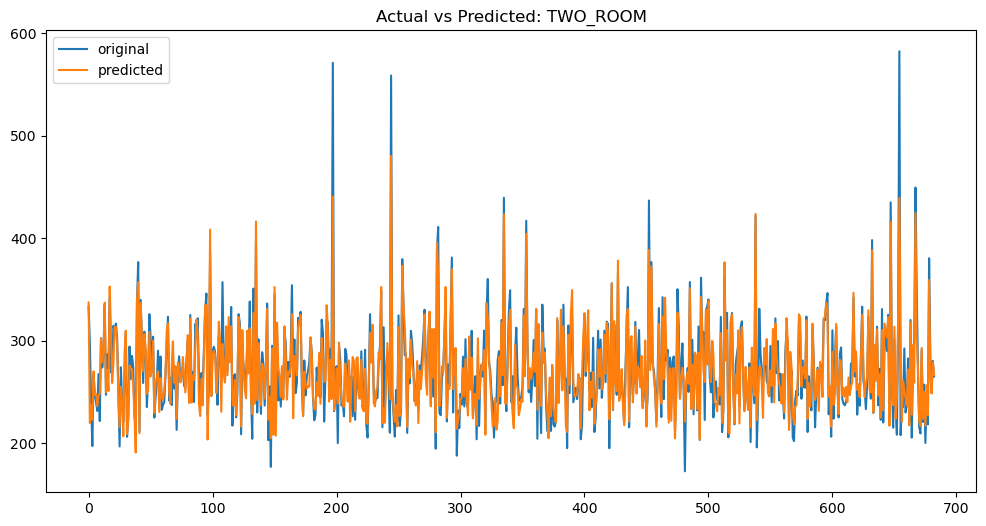



Scores for TWO_ROOM
R2 Score: 0.8379317362994421
MSE Score: 356.7469411976711
RMSE Score: 18.887745794500493
MAE Score: 12.956850856708398 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count        683.00           683.00            683.00        683.00
mean         272.46           270.81             -1.65         -0.11
std           46.95            40.95             18.83          6.69
min          172.70           191.00           -143.20        -26.03
25%          241.20           243.00            -10.75         -3.80
50%          265.50           264.00             -0.60         -0.19
75%          297.40           293.00              8.65          3.41
max          582.20           480.00             88.10         42.38

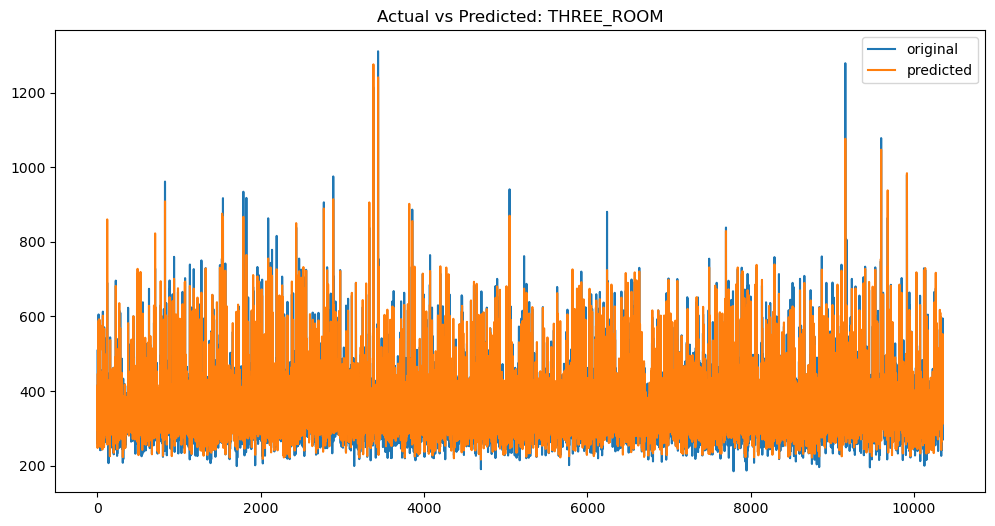



Scores for THREE_ROOM
R2 Score: 0.8952698825973908
MSE Score: 817.1935859904605
RMSE Score: 28.586598013587775
MAE Score: 21.48411129548021 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      10358.00         10358.00          10358.00      10358.00
mean         355.86           355.90              0.04          0.70
std           88.34            82.93             28.58          8.14
min          184.80           216.00           -202.40        -33.33
25%          297.60           303.00            -16.00         -4.35
50%          340.10           340.00              1.40          0.41
75%          389.50           381.00             17.60          5.47
max         1311.40          1276.00            236.10         87.77

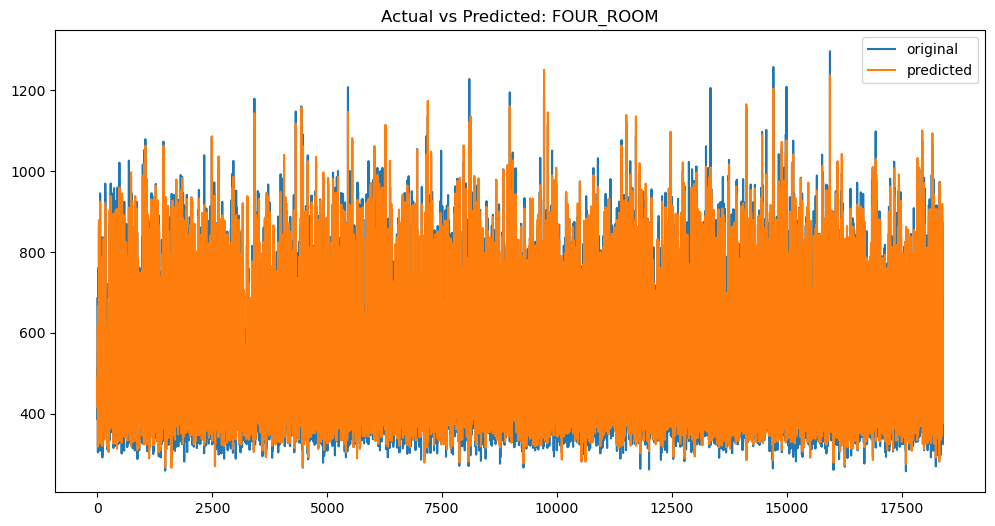



Scores for FOUR_ROOM
R2 Score: 0.9069495148005223
MSE Score: 1759.741337485589
RMSE Score: 41.949271000645396
MAE Score: 31.358542192358666 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      18401.00         18401.00          18401.00      18401.00
mean         506.37           506.50              0.13          0.82
std          137.52           128.45             41.96          8.23
min          257.60           266.00           -468.30        -49.44
25%          414.80           423.00            -22.30         -4.23
50%          475.00           479.00              3.10          0.62
75%          556.60           545.00             26.10          5.77
max         1296.70          1251.00            188.90         49.26

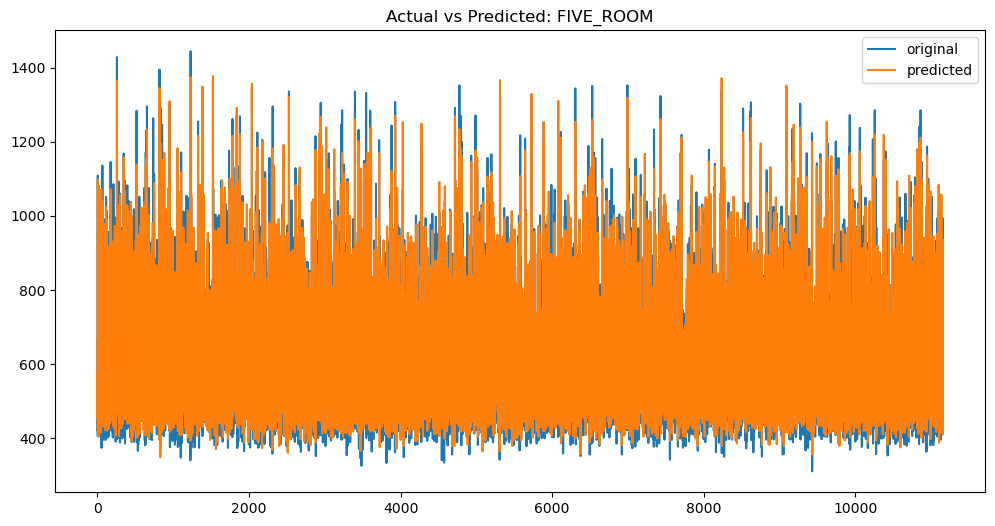



Scores for FIVE_ROOM
R2 Score: 0.9015508744401918
MSE Score: 2611.1926063580963
RMSE Score: 51.099829807525744
MAE Score: 38.092312104920566 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      11159.00         11159.00          11159.00      11159.00
mean         609.50           609.26             -0.24          0.73
std          162.87           151.79             51.10          8.23
min          311.40           349.00           -323.70        -37.48
25%          492.90           498.00            -27.30         -4.32
50%          573.10           574.00              2.90          0.53
75%          683.50           676.00             31.65          5.67
max         1444.00          1377.00            257.30         57.73

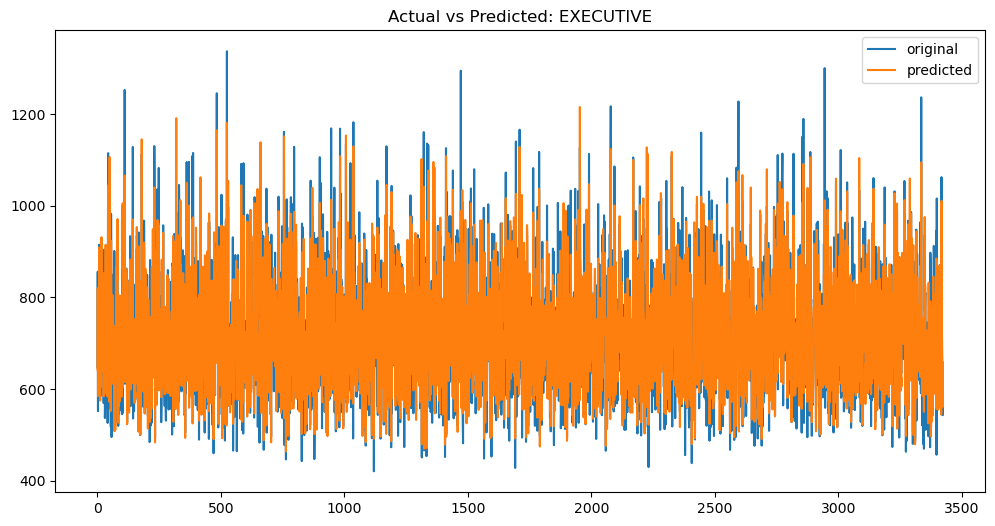



Scores for EXECUTIVE
R2 Score: 0.8437708534383614
MSE Score: 2899.7267894284273
RMSE Score: 53.84911131512225
MAE Score: 40.94381587839572 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count       3424.00          3424.00           3424.00       3424.00
mean         717.03           716.13             -0.90          0.50
std          136.26           121.19             53.85          7.38
min          420.50           464.00           -306.50        -25.55
25%          614.38           623.00            -31.70         -4.24
50%          698.55           701.00              1.60          0.25
75%          799.40           792.00             33.10          4.92
max         1337.00          1215.00            204.50         40.43

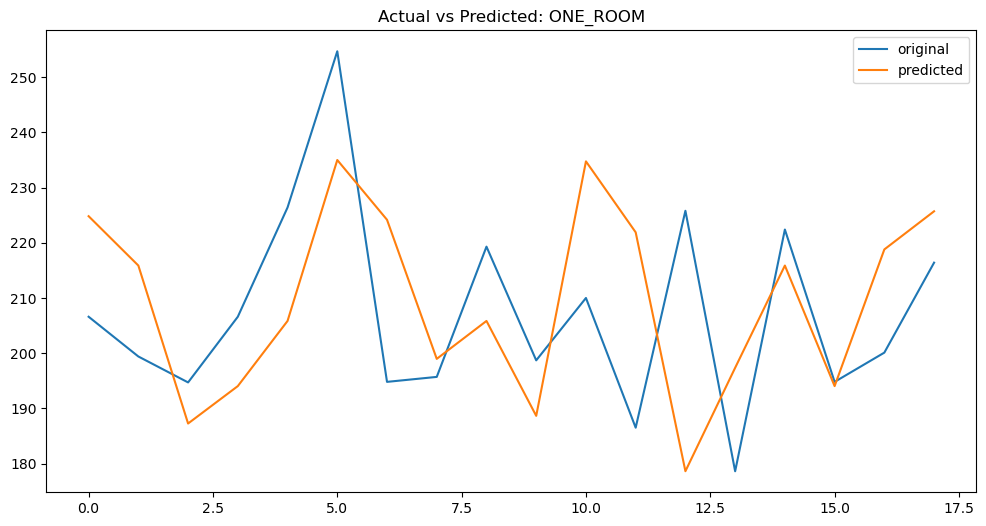



Scores for ONE_ROOM
R2 Score: -0.4095450564895913
MSE Score: 428.13125655073674
RMSE Score: 20.691332884827325
MAE Score: 17.36128811306424 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         18.00            18.00             18.00         18.00
mean         207.31           209.39              2.08          1.52
std           17.93            17.12             21.14         10.14
min          178.60           179.00            -46.80        -20.73
25%          195.02           194.75            -11.87         -5.77
50%          203.35           211.00              1.25          0.64
75%          218.58           223.50             18.40          9.31
max          254.70           235.00             35.50         19.03

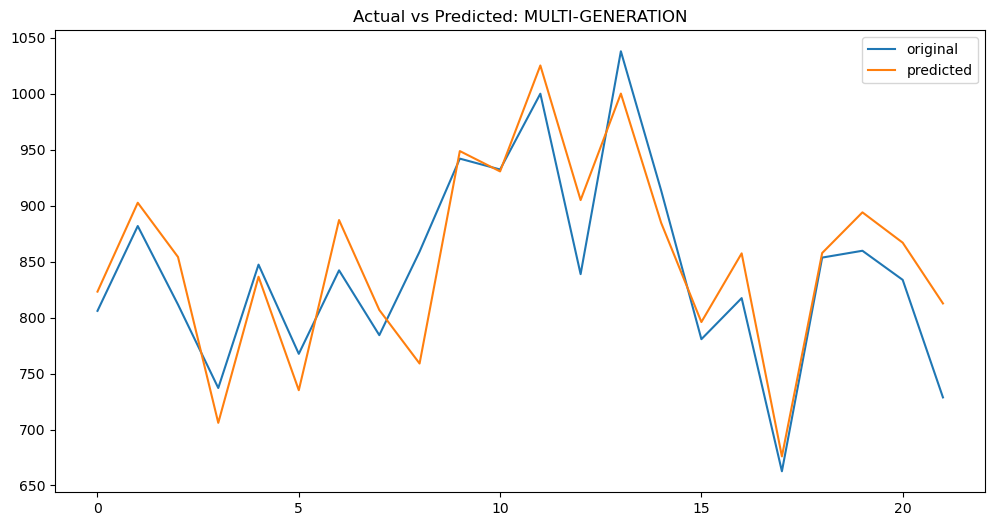



Scores for MULTI-GENERATION
R2 Score: 0.7764952595619632
MSE Score: 1630.309487564137
RMSE Score: 40.377091123112585
MAE Score: 32.407251531427555 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         22.00            22.00             22.00         22.00
mean         842.63           853.00             10.37          1.35
std           87.42            87.19             39.96          4.86
min          662.70           676.00            -99.90        -11.63
25%          789.72           808.50             -8.80         -1.04
50%          840.50           857.50             16.15          2.06
75%          876.28           900.75             34.05          3.99
max         1037.90          1025.00             84.30         11.57



CPU times: user 32.9 s, sys: 1.64 s, total: 34.5 s
Wall time: 11 s


In [50]:
%%time

def XGB_r(flat_type):
    
    # Extract the data for each flat_type
    data = dfs[flat_type]
    
    
    # Extract the data for each flat_type
    features = ['Tranc_Yr', 'Tranc_Mth', 'median_flr', 'town', 'flat_model', 'Distance_from_CBD', 'remaining_yr', 'floor_area_sqm']
    
    # Define X and y
    X = data.loc[:, features]
    y = data.loc[:, 'Adjusted_Price']
    
    # Pipeline KNN to handle null values and outliers and StandardScaler numerical columns
    num_trans = make_pipeline(KNNImputer(n_neighbors=10), 
                              StandardScaler())
    
    cat_trans = make_pipeline(OneHotEncoder())
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Creating the numerical and categorical columns
    
    cat_cols = [cname for cname in X.columns if X[cname].dtype == ['object', 'category']]
    num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
                  
    # set up the column transformer to apply OneHotEncoder and StandardScaler
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('cat', cat_trans, cat_cols),
                      ('Std', num_trans, num_cols)])
    
    #Instantiation XGBRegressor
    xgbr = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, learning_rate=0.1, seed = 27)
    
    # set up the pipeline with the column transformer and the linear regression model
    
    pipeline_xgbr = Pipeline([('preprocessor', preprocessor),
                        ('model', xgbr)])
    
    # Fit the linear regression model
    pipeline_xgbr.fit(X_train, y_train)
    
    #Scoring
    y_pred = pipeline_xgbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae= mean_absolute_error(y_test, y_pred)
    score = pipeline_xgbr.score(X_test, y_test)
    
    #Plot Graph
    fig, ax = plt.subplots(figsize=(12,6))
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("Actual vs Predicted: {}".format(flat_type))
    plt.legend()
    plt.show()
    
    print('\n')
    print('Scores for {}'.format(flat_type))
    print('R2 Score:', score)
    print('MSE Score:', mse)
    print('RMSE Score:', rmse)
    print('MAE Score:', mae, '\n')
    
    #get Actual and Predicted df
    compare = pd.DataFrame({'Actual (000)': y_test, 'Predicted (000)': y_pred})
    
    #Apply Function to round off to nearest 1000
    
    compare['Predicted (000)'] = round(compare['Predicted (000)'])


    #Get Dataframe to show the price diff between Actual and Predicted
    compare['Price Diff (000)'] = compare['Predicted (000)'] - compare['Actual (000)']
    compare['Percent Diff'] = (compare['Predicted (000)'] - compare['Actual (000)']) / compare['Actual (000)'] *100
    
    compare_styled = compare.head(30).style.format('{:.1f}', na_rep="")\
    .bar(subset=['Percent Diff'], color='#01C6BA', align='zero')
    
    display(compare_styled)
    print('\n')
    display(compare.describe().round(2))
    print('\n')
    
    
#Apply the function to each flat_type

for flat_type in dfs.keys():
    XGB_r(flat_type)

**Outcomes:**

- Overall, XGBRegressor outperforms the earlier 2 models. 
- It is able to push 2 Room R^2 score up to 0.84
- Multi-Gen R^2 score is now at 0.78
- As a preliminary round of parameter tuning, it has already gotten pretty impressive result. 
- In addition, we are seeing predicted price closer to the Actual price
- Next section we will be running with further tuning of XGB Regressor

Though this model is not the most time efficient with total CPU time of 32 secs. 

### XGB Regressor Part II

**XGB General Parameters:**
 
objective= 'reg:squarederror', 
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27

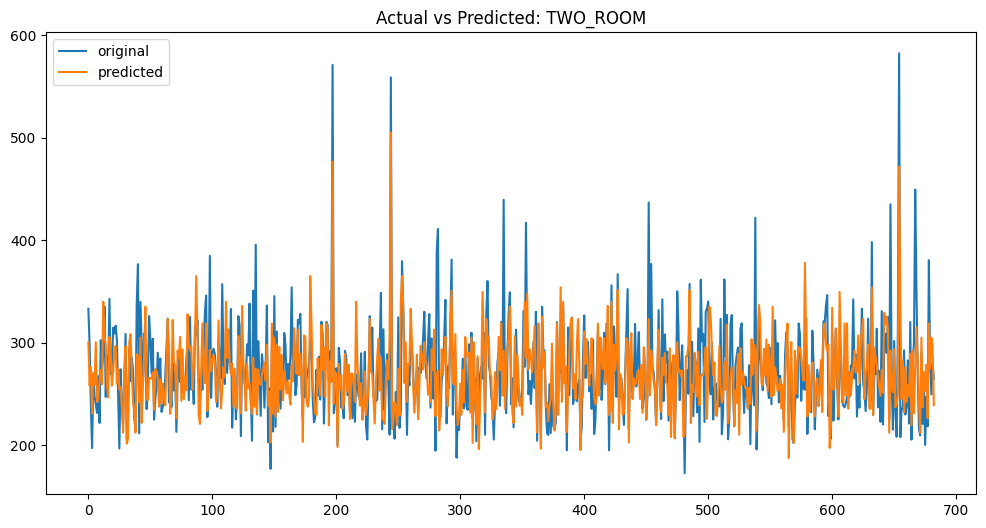

/n
Scores for TWO_ROOM
R2 Score: 0.40899836837372483
MSE Score: 1300.9211026969283
RMSE Score: 36.06828388899212
MAE Score: 26.38747669851099 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count        683.00           683.00            683.00        683.00
mean         272.46           270.40             -2.06          0.51
std           46.95            36.02             36.04         12.51
min          172.70           188.00           -174.30        -38.79
25%          241.20           245.00            -20.15         -7.22
50%          265.50           269.00             -1.00         -0.31
75%          297.40           292.00             18.45          7.67
max          582.20           505.00            131.10         63.06

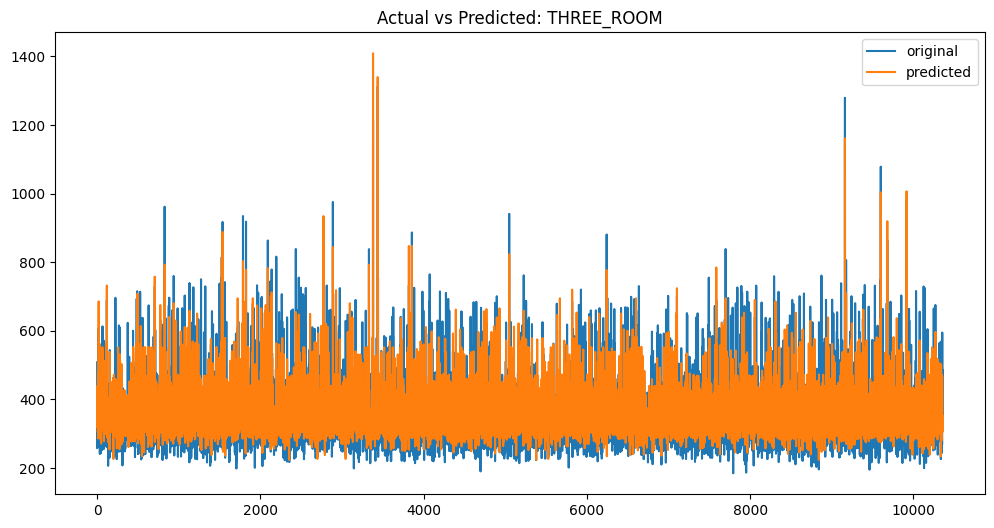

/n
Scores for THREE_ROOM
R2 Score: 0.548152722802802
MSE Score: 3525.6973440918223
RMSE Score: 59.37758284143791
MAE Score: 42.46761182426693 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      10358.00         10358.00          10358.00      10358.00
mean         355.86           355.99              0.13          2.22
std           88.34            69.61             59.38         15.55
min          184.80           224.00           -353.80        -53.70
25%          297.60           314.00            -28.17         -7.55
50%          340.10           337.00              4.50          1.35
75%          389.50           377.00             33.77         11.04
max         1311.40          1409.00            306.90        155.95

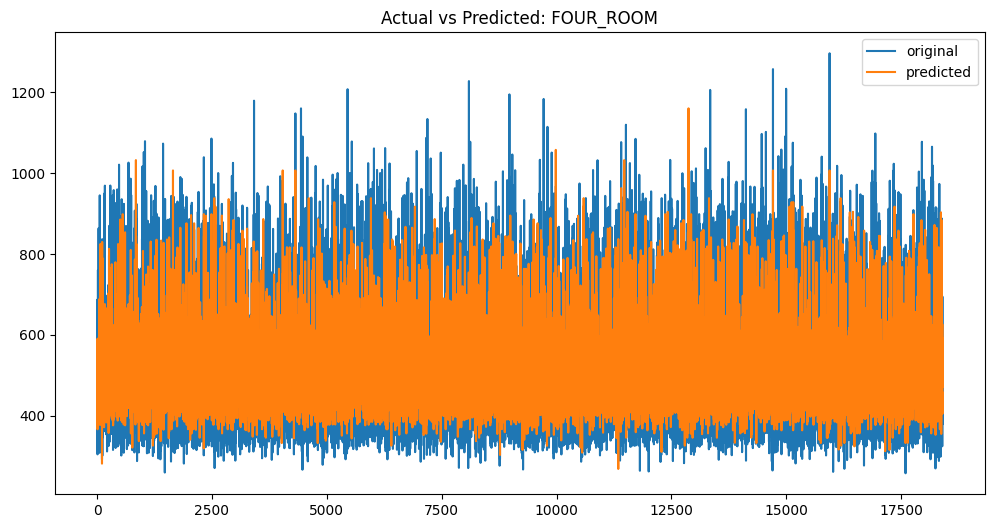

/n
Scores for FOUR_ROOM
R2 Score: 0.32279420416184523
MSE Score: 12807.101761656548
RMSE Score: 113.1684662865789
MAE Score: 81.40943611642147 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      18401.00         18401.00          18401.00      18401.00
mean         506.37           505.57             -0.80          3.82
std          137.52            85.71            113.17         20.19
min          257.60           268.00           -675.90        -55.91
25%          414.80           449.00            -43.10         -8.11
50%          475.00           490.00             17.30          3.65
75%          556.60           546.00             68.10         16.01
max         1296.70          1160.00            499.60        118.77

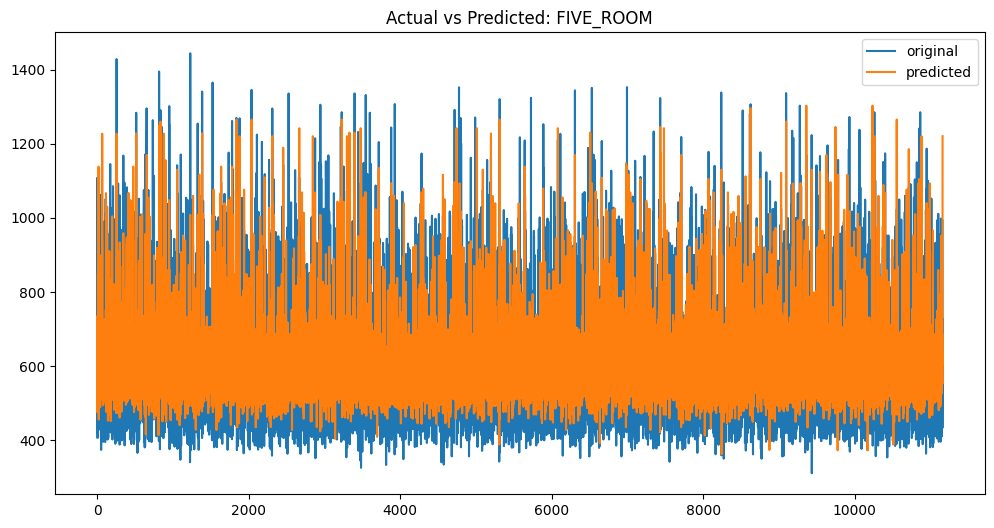

/n
Scores for FIVE_ROOM
R2 Score: 0.36417772188627173
MSE Score: 16864.08510108825
RMSE Score: 129.86179230662208
MAE Score: 93.1927512172901 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count      11159.00         11159.00          11159.00      11159.00
mean         609.50           610.20              0.70          3.90
std          162.87           109.35            129.87         19.77
min          311.40           363.00           -679.60        -56.94
25%          492.90           540.00            -47.85         -7.37
50%          573.10           587.00             21.70          3.76
75%          683.50           655.00             79.60         15.53
max         1444.00          1303.00            570.00        159.66

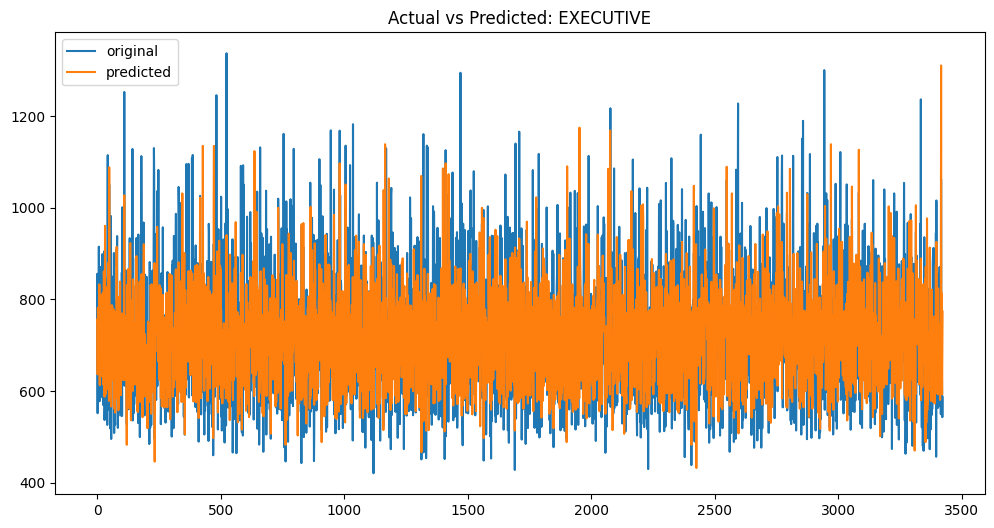

/n
Scores for EXECUTIVE
R2 Score: 0.19847180750652127
MSE Score: 14876.947249650964
RMSE Score: 121.97109186053457
MAE Score: 90.37699993703967 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count       3424.00          3424.00           3424.00       3424.00
mean         717.03           719.45              2.42          2.45
std          136.26            99.95            121.97         16.57
min          420.50           432.00           -584.20        -47.57
25%          614.38           647.00            -57.20         -7.62
50%          698.55           721.00              9.40          1.35
75%          799.40           777.00             74.60         11.59
max         1337.00          1310.00            445.20         93.02

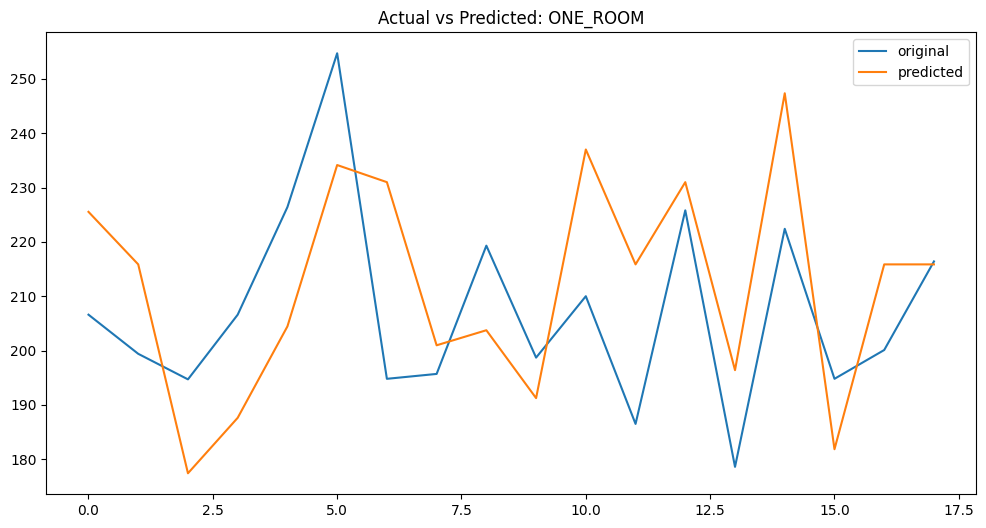

/n
Scores for ONE_ROOM
R2 Score: -0.24367773049472552
MSE Score: 377.7511808149904
RMSE Score: 19.43582210288493
MAE Score: 17.34126976860894 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         18.00            18.00             18.00         18.00
mean         207.31           211.83              4.53          2.50
std           17.93            20.24             19.49          9.50
min          178.60           177.00            -22.40         -9.89
25%          195.02           197.25            -14.68         -6.88
50%          203.35           216.00              5.25          2.51
75%          218.58           229.75             18.90          9.65
max          254.70           247.00             36.20         18.58

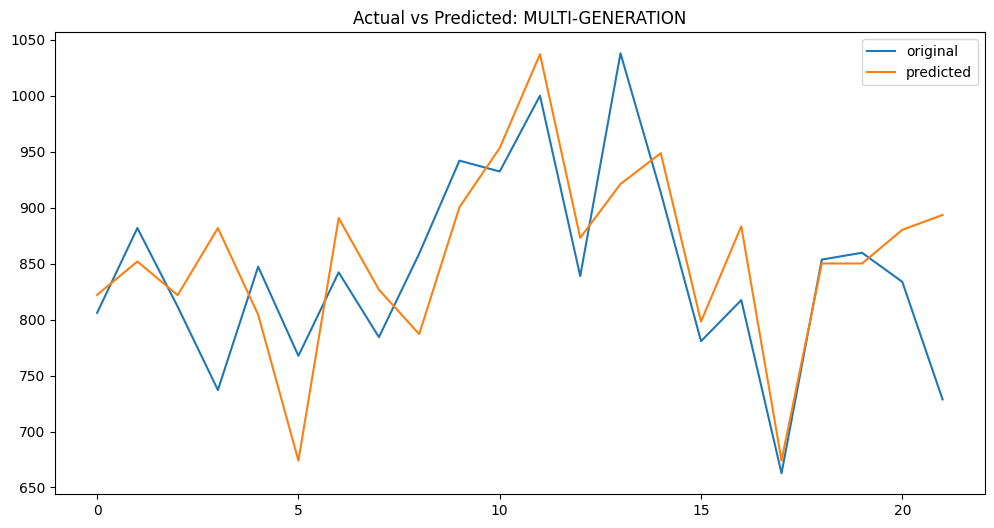

/n
Scores for MULTI-GENERATION
R2 Score: 0.40258336599354894
MSE Score: 4357.733104633491
RMSE Score: 66.01312827486281
MAE Score: 50.22216186523437 



Actual (000)  Predicted (000)  Price Diff (000)  Percent Diff
count         22.00            22.00             22.00         22.00
mean         842.63           855.55             12.91          1.90
std           87.42            82.28             66.27          8.29
min          662.70           674.00           -116.90        -12.19
25%          789.72           822.00            -24.77         -2.82
50%          840.50           862.50             16.65          2.10
75%          876.28           892.50             41.28          5.10
max         1037.90          1037.00            164.30         22.55



CPU times: total: 16.8 s
Wall time: 23.3 s


In [73]:
%%time

def tuned_XGB_r(flat_type):
    
    # Extract the data for each flat_type
    data = dfs[flat_type]
    
    
    # Extract the data for each flat_type
    features = ['Tranc_Yr', 'Tranc_Mth', 'median_flr', 'town', 'flat_model', 'Distance_from_CBD', 'remaining_yr', 'floor_area_sqm']
    
    # Define X and y
    X = data.loc[:, features]
    y = data.loc[:, 'Adjusted_Price']
    
    # Pipeline KNN to handle null values and outliers and StandardScaler numerical columns
    num_trans = make_pipeline(KNNImputer(n_neighbors=10), 
                              StandardScaler())
    
    cat_trans = make_pipeline(OneHotEncoder())
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Creating the numerical and categorical columns
    
    cat_cols = [cname for cname in X.columns if X[cname].dtype == ['object', 'category']]
    num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
                  
    # set up the column transformer to apply OneHotEncoder and StandardScaler
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[('cat', cat_trans, cat_cols),
                      ('Std', num_trans, num_cols)])
    
    #Instantiation XGBRegressor
    xgbr = xgb.XGBRegressor(objective ='reg:squarederror', 
                            learning_rate =0.1,
                            n_estimators=1250,
                            max_depth=7,
                            min_child_weight=2,
                            gamma=0,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            nthread=1,
                            scale_pos_weight=1,
                            seed=27)
    
    # set up the pipeline with the column transformer and the linear regression model
    
    pipeline_xgbr = Pipeline([('preprocessor', preprocessor),
                        ('model', xgbr)])
    
    # Fit the linear regression model
    pipeline_xgbr.fit(X_train, y_train)
    
    #Scoring
    y_pred = pipeline_xgbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae= mean_absolute_error(y_test, y_pred)
    score = pipeline_xgbr.score(X_test, y_test)
    
    #Plot Graph
    fig, ax = plt.subplots(figsize=(12,6))
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.title("Actual vs Predicted: {}".format(flat_type))
    plt.legend()
    plt.show()
    
    print("/n")
    print('Scores for {}'.format(flat_type))
    print('R2 Score:', score)
    print('MSE Score:', mse)
    print('RMSE Score:', rmse)
    print('MAE Score:', mae, '\n')
    
    #get Actual and Predicted df
    compare = pd.DataFrame({'Actual (000)': y_test, 'Predicted (000)': y_pred})
    
    #Apply Function to round off to nearest 1000
    
    compare['Predicted (000)'] = round(compare['Predicted (000)'])


    #Get Dataframe to show the price diff between Actual and Predicted
    compare['Price Diff (000)'] = compare['Predicted (000)'] - compare['Actual (000)']
    compare['Percent Diff'] = (compare['Predicted (000)'] - compare['Actual (000)']) / compare['Actual (000)'] *100
    
    compare_styled = compare.head(30).style.format('{:.1f}', na_rep="")\
    .bar(subset=['Percent Diff'], color='#01C6BA', align='zero')
    
    display(compare_styled)
    print('\n')
    display(compare.describe().round(2))
    print('\n')
    
#Apply the function to each flat_type

for flat_type in dfs.keys():
    tuned_XGB_r(flat_type)

**Final parameter settings:**

objective ='reg:squarederror',
learning_rate =0.1,
n_estimators=1250,
max_depth=7,
min_child_weight=2,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
nthread=1,
scale_pos_weight=1,
seed=27

**Score Observation:**

| Model       | 1 Room | 2 Room | 3 Room | 4 Room | 5 Room | Executive | Multi-Gen |
|-------------|--------|--------|--------|--------|--------|-----------|-----------|
| **Linear Regression**  | 
| R^2 Score   |  0.10  | 0.54   | 0.66   | 0.75   | 0.72   | 0.64      | 0.66      |
| **RandomForest Regression** | 
| R^2 Score   |  0.39  | 0.71   | 0.88   | 0.91   | 0.90   | 0.82      | 0.17      |
| **XGB Regressor**  |      
| R^2 Score   | -0.31  | 0.84   | 0.93   | 0.95   | 0.95   | 0.89      | 0.85      |

Total CPU time: 2 mins 10 secs

**Observations:**
- XGB after parameter tuning show a good result overall.
- One Room flats performs better with RandomForestResgressor after bootstrapping
- Price Difference between prediction and actual values are also closer overall. 

**Recommendations for Further Improvement:**
- Run a pipeline with XGBRegressor for Two Room to Multi-Gen flats
- One room flat with initial XGB Regressor R^2 is -0.41. We will use initial XGB pipeline for prediction. 

**--- End of Analysis ---**